## Library Imports

This notebook uses a range of Python libraries to handle data loading, preprocessing, visualization, machine learning, and model evaluation.

- **pandas, numpy**: For data manipulation
- **seaborn, matplotlib, plotly**: For data visualization
- **scikit-learn**: For preprocessing, model training, and evaluation
- **SMOTE**: To address class imbalance in the dataset
- **xgboost, random forest,lightgbm**: Machine learning models used for classification

Display settings are customized to make outputs more readable in notebook format.
**[Kaggle Source](https://www.kaggle.com/datasets/adarshsng/lending-club-loan-data-csv/data)**

In [10]:
# Import essential libraries for data manipulation and visualization
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats


# Import tools for data preprocessing and model selection
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from imblearn.over_sampling import SMOTE  # For handling class imbalance

# Import performance evaluation metrics
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    roc_auc_score, roc_curve, auc,
    ConfusionMatrixDisplay, RocCurveDisplay
)

# Import machine learning models
import lightgbm as lgb
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

# Set display options for pandas DataFrames
pd.set_option('display.float', '{:.2f}'.format)
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 50)


##  Selected Features and Justifications

| Feature               | Description                                                | Why it's Important                                                 |
|-----------------------|------------------------------------------------------------|---------------------------------------------------------------------|
| **annual_inc**         | Borrower's self-reported annual income                     | Core indicator of repayment capacity.                               |
| **loan_amnt**          | The listed amount of the loan applied for                  | Larger loans have higher risk exposure.                             |
| **term**               | The number of payments on the loan (e.g. 36 or 60 months)  | Longer terms increase uncertainty and risk.                         |
| **int_rate**           | Interest rate on the loan                                  | Higher rates may be given to riskier applicants.                    |
| **installment**        | Monthly payment owed by the borrower                       | Helps assess affordability vs income.                               |
| **dti**                | Debt-to-income ratio                                       | Key metric in evaluating financial stress.                          |
| **emp_title**          | Job title of the borrower                                  | Reflects career type, which may correlate with income stability and default risk. |
| **open_acc**           | Number of open credit lines                                | May indicate either strong credit or overextension.                 |
| **revol_util**         | Revolving credit utilization rate                          | High utilization signals financial stress.                          |
| **emp_length**         | Employment length in years                                 | Longer employment usually implies income stability.                |
| **purpose**            | Purpose of the loan (e.g., debt consolidation, business)   | Certain purposes (e.g. small business) are riskier.                 |
| **home_ownership**     | Homeownership status (rent, own, mortgage)                 | Owning can be a proxy for financial security.                       |
| **verification_status**| Income verification status                                 | Verified income is more trustworthy.                                |
| **application_type**   | Individual or joint application                            | Joint applications may show combined financial strength.            |
| **grade**              | Loan grade assigned by Lending Club                        | Indicates Lending Club’s risk categorization.                       |
| **sub_grade**          | More granular loan grade                                   | Adds nuance to grade.                                               |


## Data Loading and Filtering

We begin by selecting important financial and categorical features relevant for predicting loan default.

The dataset is then filtered to include only two loan statuses:
- **Fully Paid**
- **Charged Off**

This converts the target variable into a binary classification problem, where the goal is to predict whether a loan will be fully paid or charged off.


In [4]:
# Define the selected features to be used in the model
selected_features = [
    'annual_inc', 'loan_amnt', 'term', 'int_rate', 'installment', 'dti',
    'emp_title', 'open_acc', 'revol_util', 'emp_length', 'purpose',
    'home_ownership', 'verification_status', 'application_type',
    'grade', 'sub_grade', 'loan_status'  # 'loan_status' will be the target variable
]

# Load the dataset with only the selected features
df = pd.read_csv(r'G:\Other computers\My Laptop\Education and Bootcamp\Projects\Machine Learning Predictions\Loan Default Prediction\loan.csv', usecols=selected_features)

# Define target statuses for binary classification
target_statuses = ['Fully Paid', 'Charged Off']

# Filter the dataset to include only relevant loan statuses
filtered_df = df[df['loan_status'].isin(target_statuses)].copy()

# Display the first few rows of the filtered dataset
filtered_df.head()


,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,loan_status,purpose,dti,open_acc,revol_util,application_type
100,30000,36 months,22.35,1151.16,D,D5,Supervisor,5 years,MORTGAGE,100000.00,Source Verified,Fully Paid,debt_consolidation,30.46,11.00,37.00,Joint App
152,40000,60 months,16.14,975.71,C,C4,Assistant to the Treasurer (Payroll),< 1 year,MORTGAGE,45000.00,Verified,Fully Paid,credit_card,50.53,18.00,64.50,Joint App
170,20000,36 months,7.56,622.68,A,A3,Teacher,10+ years,MORTGAGE,100000.00,Not Verified,Fully Paid,credit_card,18.92,9.00,29.90,Joint App
186,4500,36 months,11.31,147.99,B,B3,Accounts Examiner III,10+ years,RENT,38500.00,Not Verified,Fully Paid,credit_card,4.64,12.00,15.30,Individual
215,8425,36 months,27.27,345.18,E,E5,Senior Director Risk Management,3 years,MORTGAGE,450000.00,Verified,Fully Paid,credit_card,12.37,21.00,65.70,Joint App


## Descriptive Statistics

We use `describe().T` to generate summary statistics for the numerical features in the filtered dataset.

This includes:
- **count**: Number of non-missing entries
- **mean**: Average value
- **std**: Standard deviation
- **min, max**: Range of values
- **25%, 50%, 75%**: Quartiles to understand data distribution

This step provides a quick overview of the central tendency and spread of key financial variables.


In [5]:
# Generate and display transposed descriptive statistics for numerical features
filtered_df.describe().T

,count,mean,std,min,25%,50%,75%,max
loan_amnt,1303607.00,14416.81,8699.54,500.00,8000.00,12000.00,20000.00,40000.00
int_rate,1303607.00,13.26,4.76,5.31,9.75,12.74,15.99,30.99
installment,1303607.00,438.08,261.06,4.93,248.82,375.43,580.45,1719.83
annual_inc,1303607.00,76158.99,70048.90,0.00,45840.00,65000.00,90000.00,10999200.00
dti,1303295.00,18.26,10.94,-1.00,11.79,17.61,24.04,999.00
open_acc,1303607.00,11.59,5.47,0.00,8.00,11.00,14.00,90.00
revol_util,1302797.00,51.91,24.50,0.00,33.60,52.30,70.80,892.30


## Descriptive Statistics for Categorical Features

This step provides a summary of the categorical (object-type) features in the dataset using `describe(include='object')`.

It includes:
- **count**: Number of non-null entries
- **unique**: Number of unique values
- **top**: Most frequent category
- **freq**: Frequency of the most common category

This helps identify dominant categories and potential areas for encoding or cleaning.


In [6]:
# Generate and display transposed descriptive statistics for categorical features
filtered_df.describe(include='object').T

,count,unique,top,freq
term,1303607,2,36 months,988754
grade,1303607,7,B,380152
sub_grade,1303607,35,C1,82815
emp_title,1221028,371435,Teacher,20496
emp_length,1228153,11,10+ years,428547
home_ownership,1303607,6,MORTGAGE,645496
verification_status,1303607,3,Source Verified,503726
loan_status,1303607,2,Fully Paid,1041952
purpose,1303607,14,debt_consolidation,757591
application_type,1303607,2,Individual,1280370


## Dataset Information

The `info()` method is used to inspect the structure of the dataset.

It reveals:
- **Column names**
- **Data types (e.g., int64, float64, object)**
- **Non-null value counts** per column
- **Overall memory usage**

This is useful for identifying missing data and verifying that the types align with expectations before preprocessing.


In [7]:
# Display information about the dataframe including data types and non-null counts
filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1303607 entries, 100 to 2260664
Data columns (total 17 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   loan_amnt            1303607 non-null  int64  
 1   term                 1303607 non-null  object 
 2   int_rate             1303607 non-null  float64
 3   installment          1303607 non-null  float64
 4   grade                1303607 non-null  object 
 5   sub_grade            1303607 non-null  object 
 6   emp_title            1221028 non-null  object 
 7   emp_length           1228153 non-null  object 
 8   home_ownership       1303607 non-null  object 
 9   annual_inc           1303607 non-null  float64
 10  verification_status  1303607 non-null  object 
 11  loan_status          1303607 non-null  object 
 12  purpose              1303607 non-null  object 
 13  dti                  1303295 non-null  float64
 14  open_acc             1303607 non-null  float64
 15  r

## Dataset Dimensions

The `shape` attribute returns the dimensions of the filtered dataset as a tuple:

- The first value is the **number of rows** (loan records).
- The second value is the **number of columns** (features including the target variable).

This helps confirm the dataset size after filtering and before further preprocessing.


In [8]:
# Display the number of rows and columns in the filtered dataset
filtered_df.shape

(1303607, 17)

## Loan Status Distribution

This visualization shows the number of loans that were either **Fully Paid** or **Charged Off**.

Steps:
- We count the occurrences of each loan status.
- A horizontal bar chart is generated using Plotly Express.
- Custom colors are applied for better visual distinction.

This chart helps understand the class distribution, which is crucial for identifying class imbalance in the target variable.


C:\Users\Ak\AppData\Local\Temp\ipykernel_9504\3921529049.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


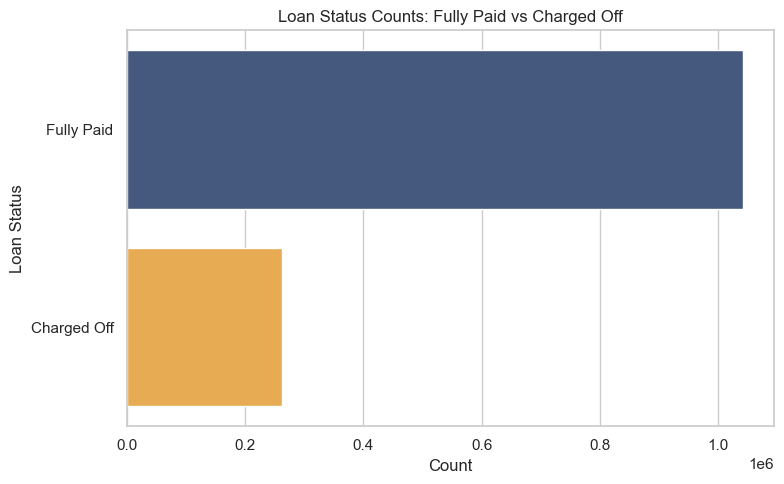

In [11]:
# Get the count of each loan status (Fully Paid vs Charged Off)
status_counts = filtered_df['loan_status'].value_counts().reset_index()
status_counts.columns = ['loan_status', 'count']

# Set custom color palette manually
color_palette = {
    'Fully Paid': '#3c5587',
    'Charged Off': '#ffaf3c'
}

# Set plot style
sns.set(style="whitegrid")

# Create the horizontal bar plot
plt.figure(figsize=(8, 5))
sns.barplot(
    data=status_counts,
    y='loan_status',
    x='count',
    palette=[color_palette[status] for status in status_counts['loan_status']]
)

# Add titles and labels
plt.title('Loan Status Counts: Fully Paid vs Charged Off')
plt.xlabel('Count')
plt.ylabel('Loan Status')

# Show the plot
plt.tight_layout()
plt.show()

## Correlation Matrix for Numerical Features

To explore relationships between numeric variables, we:

- Extract all numerical columns.
- Compute the Pearson correlation matrix.
- Visualize the correlations using a heatmap.

This helps identify:
- Highly correlated features that may cause multicollinearity.
- Redundant variables.
- Insights into which features might be most predictive of the target.

The color scale and values offer a quick way to spot both strong positive and negative relationships.


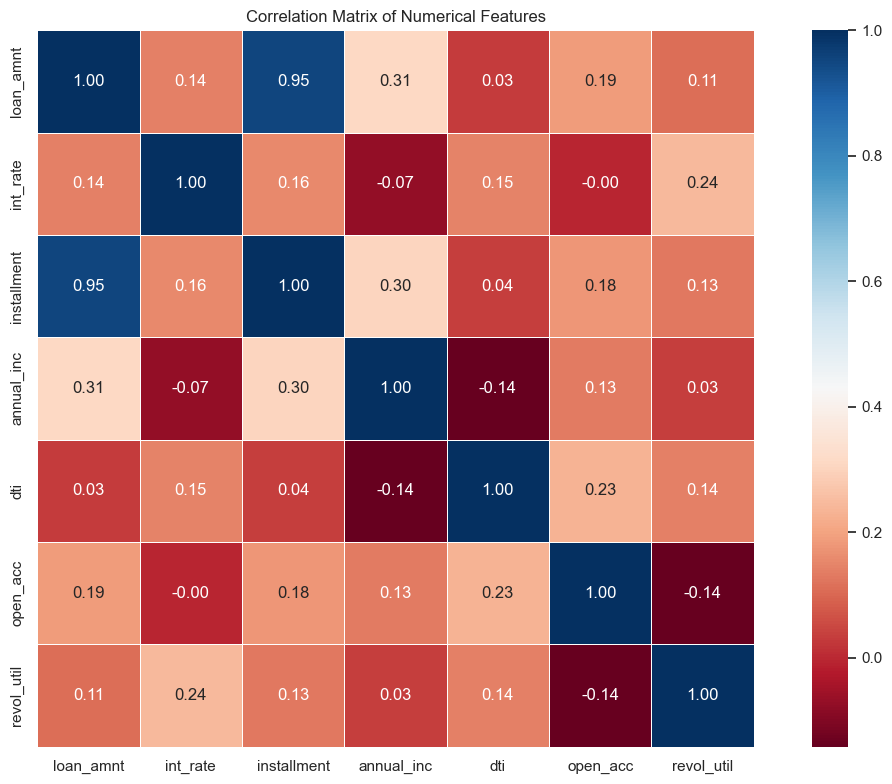

In [12]:
# Select only numerical features from the filtered dataset
numerical_df = filtered_df.select_dtypes(include=['float64', 'int64'])

# Calculate the correlation matrix for numerical features
corr_matrix = numerical_df.corr()

# Set figure size for the heatmap
plt.figure(figsize=(12, 8))

# Plot the heatmap to visualize correlations between numerical features
sns.heatmap(
    corr_matrix,
    annot=True,       # Show correlation values
    fmt=".2f",         # Format to 2 decimal places
    cmap='RdBu',       # Diverging color palette
    square=True,       # Make cells square-shaped
    linewidths=0.5     # Add lines between cells
)

# Add a title and adjust layout
plt.title('Correlation Matrix of Numerical Features')
plt.tight_layout()
plt.show()

## Distribution of Installment by Loan Status

This interactive histogram compares the distribution of **installment amounts** for loans that were *Fully Paid* vs *Charged Off*.

Key configuration details:
- Histogram bars are overlaid to highlight differences between loan statuses.
- Transparency (`opacity=0.5`) makes overlaps visible.
- Custom colors distinguish each loan status category.

This visualization helps assess whether installment size correlates with default risk.


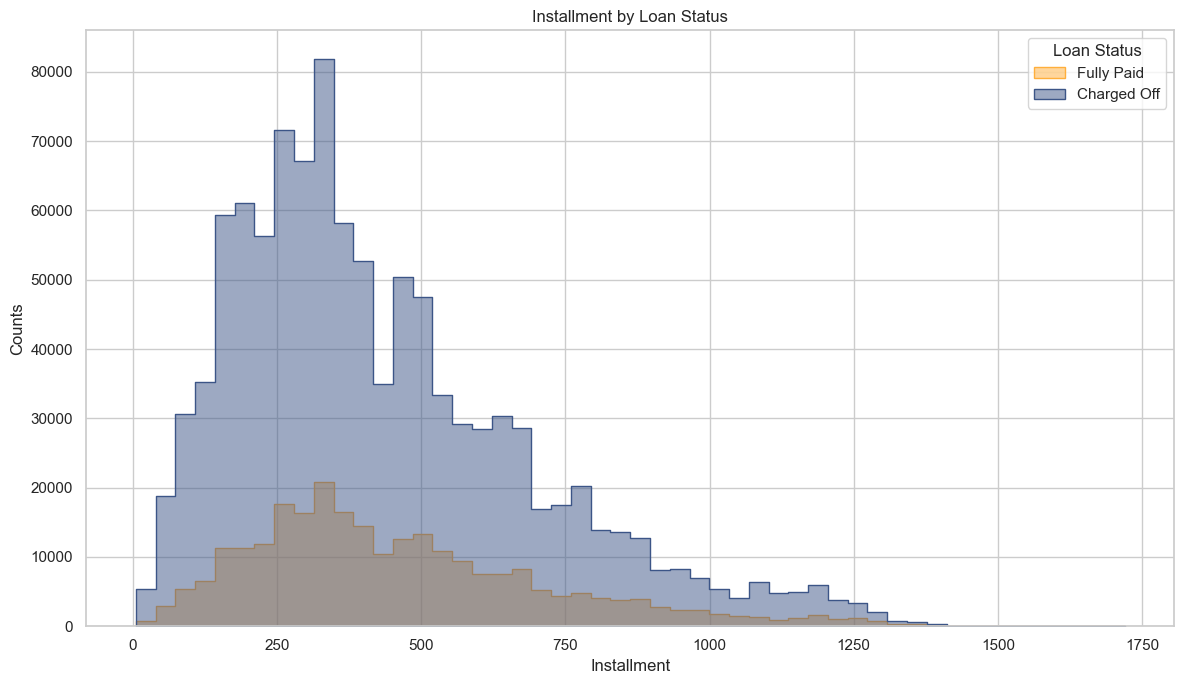

In [45]:
# Set the style
sns.set(style="whitegrid")

# Create the histogram
plt.figure(figsize=(12, 7))  # Approx. Width=1000px, Height=600px
ax = sns.histplot(
    data=filtered_df,
    x='installment',
    hue='loan_status',
    bins=50,
    element='step',        # Step style for better overlay visibility
    stat='count',
    common_norm=False,
    palette={'Fully Paid': '#3c5587', 'Charged Off': '#ffaf3c'},
    alpha=0.5
)

# Add title and axis labels
plt.title('Installment by Loan Status')
plt.xlabel('Installment')
plt.ylabel('Counts')

# Force a legend to appear even if Seaborn skips it
handles, labels = ax.get_legend_handles_labels()
if handles:
    plt.legend(handles=handles, labels=labels, title='Loan Status')
else:
    plt.legend(['Fully Paid', 'Charged Off'], title='Loan Status')

# Show the plot
plt.tight_layout()
plt.show()

## Distribution of Loan Amount by Loan Status

This histogram illustrates how **loan amount** is distributed across the two loan status categories: *Fully Paid* and *Charged Off*.

Details:
- The bars are overlaid for easier comparison.
- Custom colors distinguish each status.
- Helps identify if certain loan amounts are more prone to default.

Understanding these trends can guide lenders in setting limits or applying stricter checks for high-risk ranges.



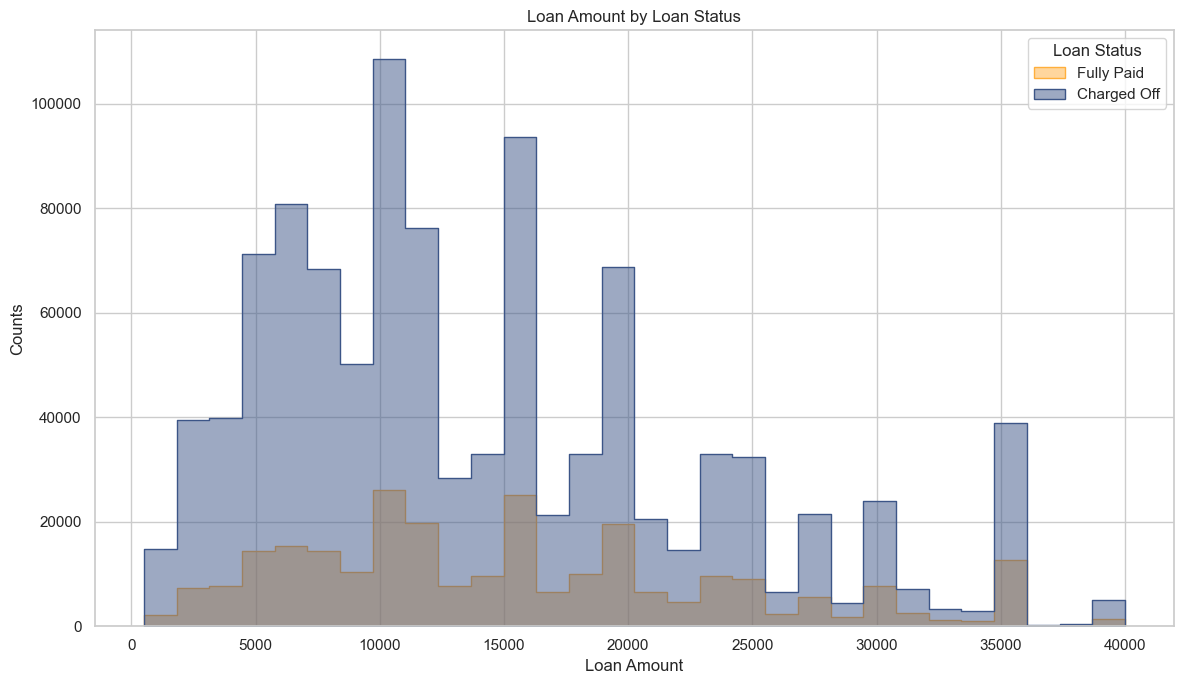

In [46]:
# Set visual style
sns.set(style="whitegrid")

# Create the histogram
plt.figure(figsize=(12, 7))  # Approx. width=1000px, height=600px
sns.histplot(
    data=filtered_df,
    x='loan_amnt',
    hue='loan_status',
    bins=30,
    element='step',  # Use 'step' for overlaid transparent look
    stat='count',
    common_norm=False,  # Keep raw counts, not normalized
    palette={'Fully Paid': '#3c5587', 'Charged Off': '#ffaf3c'},
    alpha=0.5           # Match Plotly transparency
)

# Add titles and labels
plt.title('Loan Amount by Loan Status')
plt.xlabel('Loan Amount')
plt.ylabel('Counts')

# Force a legend to appear even if Seaborn skips it
handles, labels = ax.get_legend_handles_labels()
if handles:
    plt.legend(handles=handles, labels=labels, title='Loan Status')
else:
    plt.legend(['Fully Paid', 'Charged Off'], title='Loan Status')

# Show the plot
plt.tight_layout()
plt.show()


## Box Plot: Loan Amount by Loan Status

This box plot visualizes the distribution of **loan amounts** across two categories:
- *Fully Paid*
- *Charged Off*

Key insights:
- It highlights the **median**, **interquartile range (IQR)**, and **outliers**.
- Allows easy comparison of central tendency and spread between groups.
- Helps identify if higher loan amounts are associated with greater default risk.

Box plots are particularly effective in showing distribution shape and variability across categories.


C:\Users\Ak\AppData\Local\Temp\ipykernel_9504\4005381098.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


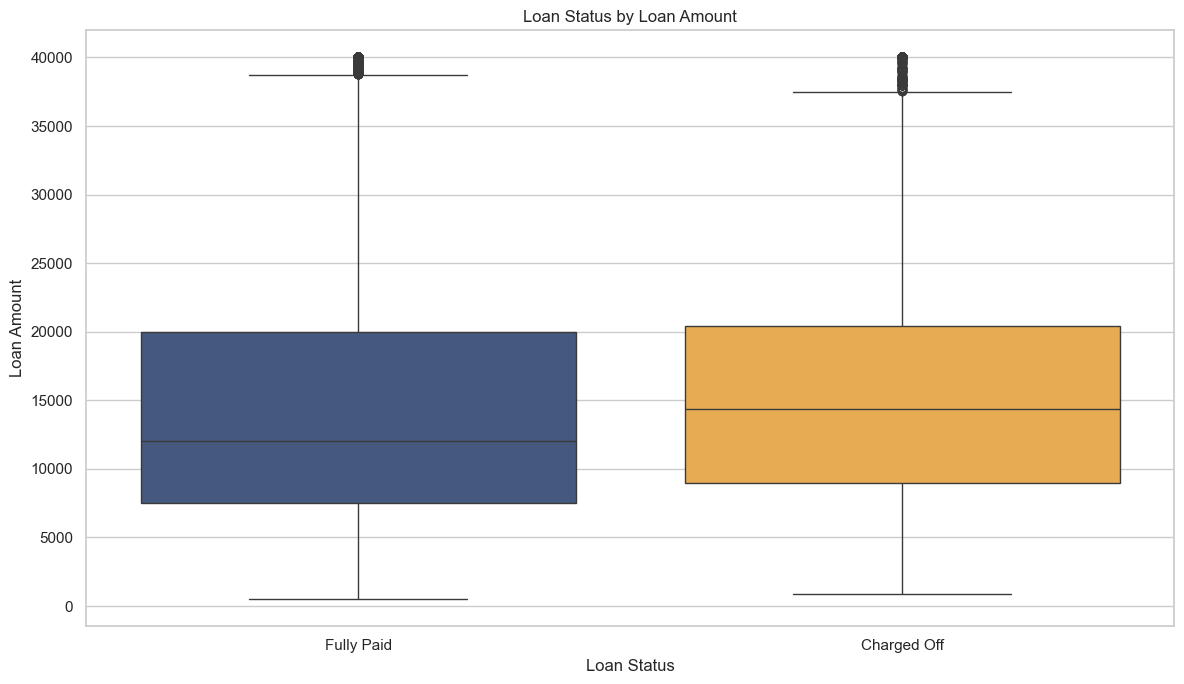

In [15]:
# Set the visual style
sns.set(style="whitegrid")

# Create the box plot
plt.figure(figsize=(12, 7))  # Approx. width=1000px, height=600px
sns.boxplot(
    data=filtered_df,
    x='loan_status',
    y='loan_amnt',
    palette={'Fully Paid': '#3c5587', 'Charged Off': '#ffaf3c'}
)

# Customize plot labels and title
plt.title('Loan Status by Loan Amount')
plt.xlabel('Loan Status')
plt.ylabel('Loan Amount')

# No legend needed since x-axis already indicates categories
plt.tight_layout()
plt.show()


## Box Plot: Installment by Loan Status

This box plot shows the distribution of **monthly installment amounts** for loans that were:
- *Fully Paid*
- *Charged Off*

Why it's useful:
- Highlights differences in central tendency and spread.
- Shows outliers that may influence loan performance.
- Reveals whether higher installment amounts correlate with default risk.

Box plots are valuable for comparing feature distributions across target categories.


C:\Users\Ak\AppData\Local\Temp\ipykernel_9504\3474006816.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


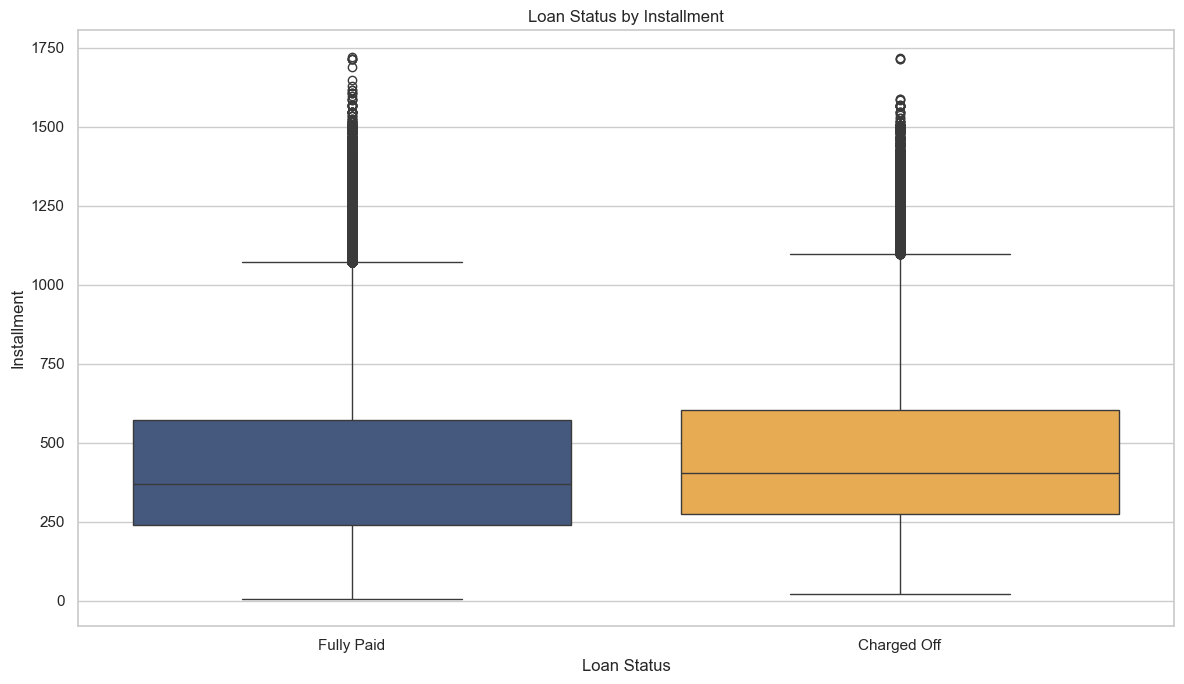

In [16]:
# Set plot style
sns.set(style="whitegrid")

# Create the box plot
plt.figure(figsize=(12, 7))  # Approx. 1000x600 pixels
sns.boxplot(
    data=filtered_df,
    x='loan_status',
    y='installment',
    palette={'Fully Paid': '#3c5587', 'Charged Off': '#ffaf3c'}
)

# Customize title and axis labels
plt.title('Loan Status by Installment')
plt.xlabel('Loan Status')
plt.ylabel('Installment')

# Hide legend (not needed)
plt.tight_layout()
plt.show()

## Loan Amount Summary by Loan Status

This command provides descriptive statistics for **loan amount**, grouped by each loan status:

- **count**: Number of loans
- **mean**: Average loan amount
- **std**: Standard deviation
- **min, max**: Range of loan amounts
- **25%, 50%, 75%**: Percentiles (Q1, Median, Q3)

These insights help assess whether loan amounts differ significantly between *Fully Paid* and *Charged Off* loans, which can indicate potential risk patterns.


In [17]:
# Generate descriptive statistics for loan amount grouped by loan status
filtered_df.groupby(by='loan_status')['loan_amnt'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,261655.00,15548.98,8797.54,900.00,9000.00,14350.00,20400.00,40000.00
Fully Paid,1041952.00,14132.49,8651.52,500.00,7500.00,12000.00,20000.00,40000.00


## Exploring Unique Loan Grades and Sub-Grades

This step prints the unique values for:
- **grade**: Broad credit grading category (e.g., A–G)
- **sub_grade**: More granular sub-categories within each grade (e.g., A1, A2, ..., G5)

Understanding these values helps inform:
- Encoding strategies (e.g., ordinal encoding if the grades follow a logical order)
- Grouping or binning for feature simplification
- Risk stratification based on creditworthiness

These features often correlate with interest rates and default probability.


In [18]:
# Print all unique values found in the 'grade' column
print(f"GRADE unique: {filtered_df.grade.unique()}")

# Print all unique values found in the 'sub_grade' column
print(f"SUB_GRADE unique: {filtered_df.sub_grade.unique()}")

GRADE unique: ['D' 'C' 'A' 'B' 'E' 'G' 'F']
SUB_GRADE unique: ['D5' 'C4' 'A3' 'B3' 'E5' 'D1' 'C1' 'A4' 'E1' 'B5' 'E4' 'B1' 'D2' 'B4'
 'B2' 'C3' 'A5' 'C2' 'A2' 'C5' 'D3' 'D4' 'E2' 'A1' 'E3' 'G2' 'F1' 'G4'
 'F2' 'F4' 'F3' 'F5' 'G1' 'G5' 'G3']


## Loan Status by Grade

This grouped bar chart visualizes how loan outcomes (Fully Paid vs Charged Off) vary across **credit grades**.

Steps involved:
1. Count total loans per grade and sort by frequency.
2. Group data by both `grade` and `loan_status`.
3. Plot grouped bars to compare status counts within each grade.

**Insights:**
- Higher grades (e.g., A, B) tend to have more fully paid loans.
- Lower grades (e.g., F, G) may show higher default rates.
- This visualization is useful for understanding how creditworthiness correlates with loan outcomes.


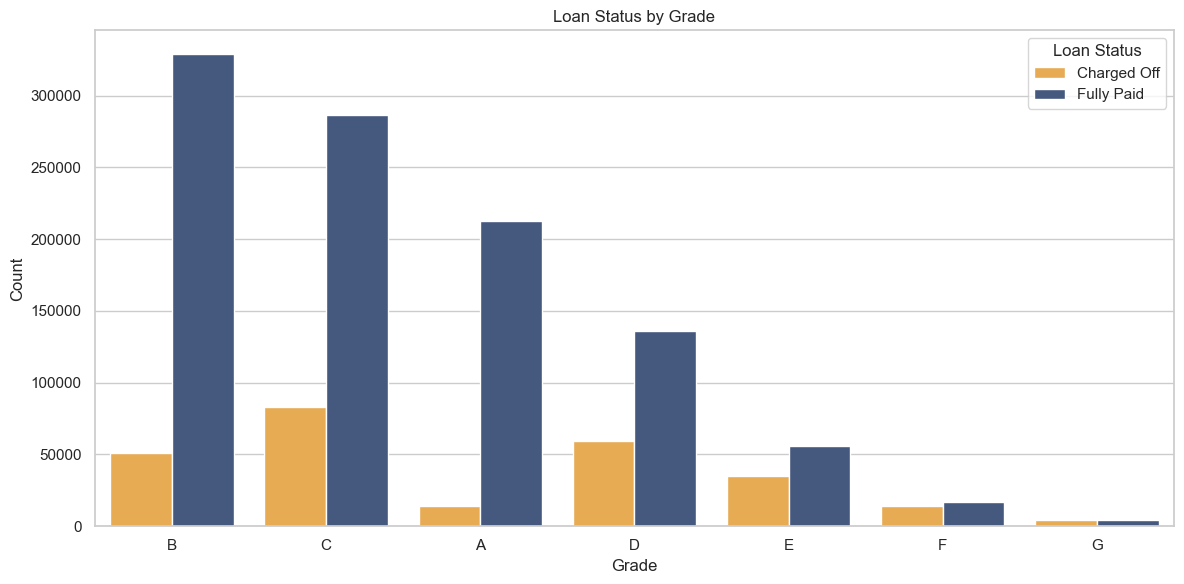

In [ ]:
# Count total loans per grade and sort by frequency
grade_totals = filtered_df['grade'].value_counts().reset_index()
grade_totals.columns = ['grade', 'total']
grade_order_desc = grade_totals.sort_values('total', ascending=False)['grade']

# Group by grade and loan status to count occurrences
grade_counts = filtered_df.groupby(['grade', 'loan_status']).size().reset_index(name='count')

# Step 3: Set grade as an ordered categorical variable based on total count
grade_counts['grade'] = pd.Categorical(grade_counts['grade'], categories=grade_order_desc, ordered=True)
grade_counts = grade_counts.sort_values('grade')

# Set plot style
sns.set(style="whitegrid")

# Set figure size (approx. 1000x500 pixels)
plt.figure(figsize=(12, 6))

# Create a grouped bar chart
sns.barplot(
    data=grade_counts,
    x='grade',
    y='count',
    hue='loan_status',
    palette={'Fully Paid': '#3c5587', 'Charged Off': '#ffaf3c'}
)

# Customize labels and title
plt.title('Loan Status by Grade')
plt.xlabel('Grade')
plt.ylabel('Count')
plt.legend(title='Loan Status')
plt.xticks(rotation=0)  # Keep x-axis labels horizontal

# Show the plot
plt.tight_layout()
plt.show()

## Loan Status by Sub Grade

This grouped bar chart visualizes the distribution of loan outcomes (*Fully Paid* vs *Charged Off*) across each **sub-grade**, which offers a more granular view than the main credit grades.

Steps:
1. Calculate total loans per `sub_grade`.
2. Group and count occurrences of each loan status within each sub-grade.
3. Sort sub-grades by volume and plot grouped bars for comparison.

**Insights:**
- Sub-grades reveal more detailed risk patterns than overall grades.
- Charged-off loans may cluster in specific sub-grades (e.g., D5, E3, G4).
- This is useful for fine-tuning lending policies based on credit segments.

Lenders can use this to identify high-risk segments at a more detailed level than overall grade alone.


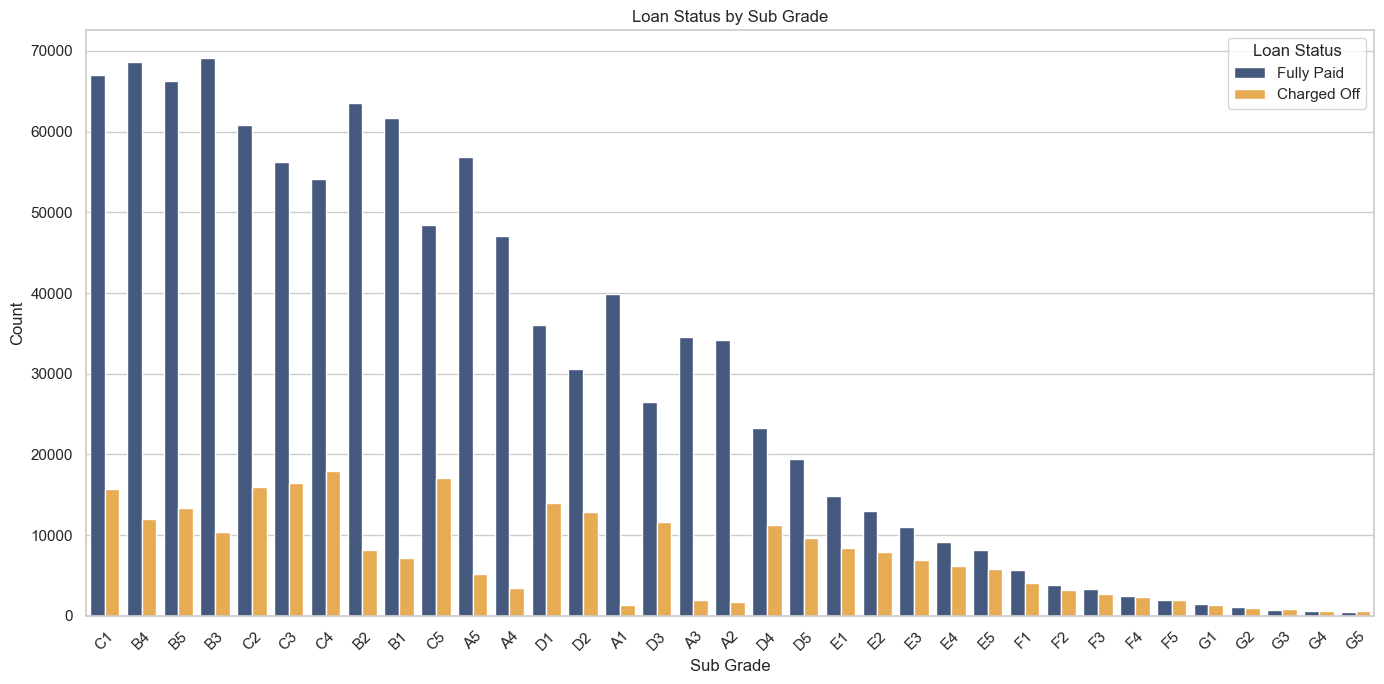

In [20]:
# Count total loans per sub_grade and sort by frequency
total_counts = filtered_df['sub_grade'].value_counts().reset_index()
total_counts.columns = ['sub_grade', 'total']
subgrade_order = total_counts.sort_values(by='total', ascending=False)['sub_grade']

# Group by sub_grade and loan_status to get count per combination
subgrade_counts = filtered_df.groupby(['sub_grade', 'loan_status']).size().reset_index(name='count')

# Set sub_grade as an ordered categorical variable based on total volume
subgrade_counts['sub_grade'] = pd.Categorical(
    subgrade_counts['sub_grade'],
    categories=subgrade_order,
    ordered=True
)
subgrade_counts = subgrade_counts.sort_values('sub_grade')

# Set visual style
sns.set(style="whitegrid")

# Set figure size (approx. 1200x600 pixels)
plt.figure(figsize=(14, 7))

# Create grouped bar chart using hue for loan_status
sns.barplot(
    data=subgrade_counts,
    x='sub_grade',
    y='count',
    hue='loan_status',
    palette={'Fully Paid': '#3c5587', 'Charged Off': '#ffaf3c'}
)

# Customize labels and title
plt.title('Loan Status by Sub Grade')
plt.xlabel('Sub Grade')
plt.ylabel('Count')
plt.legend(title='Loan Status')
plt.xticks(rotation=45)  # Tilt x-axis labels for readability

# Show the plot
plt.tight_layout()
plt.show()

## Loan Status for Grade F and G Loans Only

This focused bar chart shows the distribution of **loan status** (*Fully Paid* vs *Charged Off*) specifically for the highest-risk credit grades: **F and G**.

Purpose:
- Isolate lower credit grades to analyze default behavior in risky segments.
- Highlight how often loans in these categories result in charge-offs.

**Insights:**
- Grade F and G loans tend to have higher default rates.
- Useful for lenders to refine risk thresholds or implement stricter approval criteria in these categories.


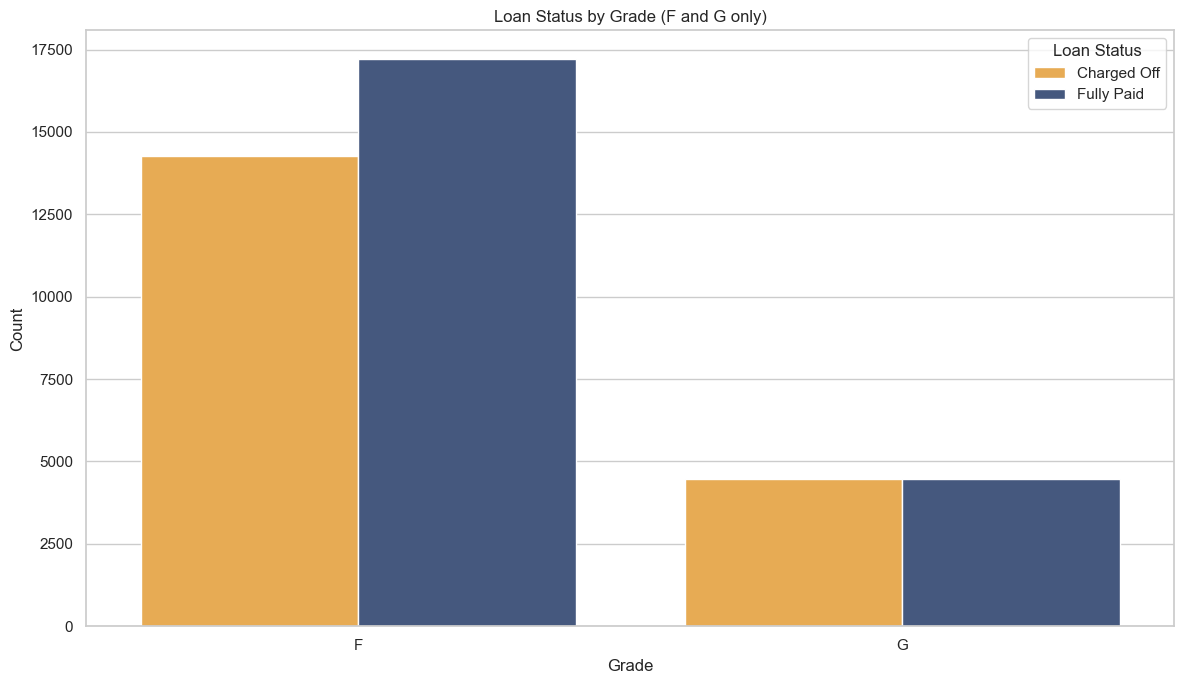

In [21]:
# Filter dataset to include only Grade F and G loans
df_fg = filtered_df[filtered_df['grade'].isin(['F', 'G'])]

# Count loan status occurrences within Grades F and G
grade_counts = df_fg.groupby(['grade', 'loan_status']).size().reset_index(name='count')

#Ensure 'grade' is ordered for consistent display
grade_counts['grade'] = pd.Categorical(grade_counts['grade'], categories=['F', 'G'], ordered=True)
grade_counts = grade_counts.sort_values('grade')

# Set the style
sns.set(style="whitegrid")

# Ensure consistent order of 'grade' (already set using pd.Categorical in your code)
plt.figure(figsize=(12, 7))  # Approx. 1000x600 pixels

# Create grouped bar plot
sns.barplot(
    data=grade_counts,
    x='grade',
    y='count',
    hue='loan_status',
    palette={'Fully Paid': '#3c5587', 'Charged Off': '#ffaf3c'}
)

# Customize title and axis labels
plt.title('Loan Status by Grade (F and G only)')
plt.xlabel('Grade')
plt.ylabel('Count')
plt.legend(title='Loan Status')

# Display the plot
plt.tight_layout()
plt.show()


## Loan Status by Sub Grade (F and G Only)

This grouped bar chart visualizes how loan performance (*Fully Paid* vs *Charged Off*) differs across **sub-grades** within Grades **F and G**.

Steps:
- Filter data to include only Grades F and G.
- Group by `sub_grade` and `loan_status` to count outcomes.
- Plot grouped bars for each sub-grade.

**Insights:**
- Reveals sub-grade-level risk patterns in the riskiest loan categories.
- Helps lenders identify which specific sub-grades (e.g., G4, F5) show extreme default behavior.
- Useful for fine-tuning credit policy at a more granular level than grade alone.

This analysis supports better decision-making in high-risk lending segments.


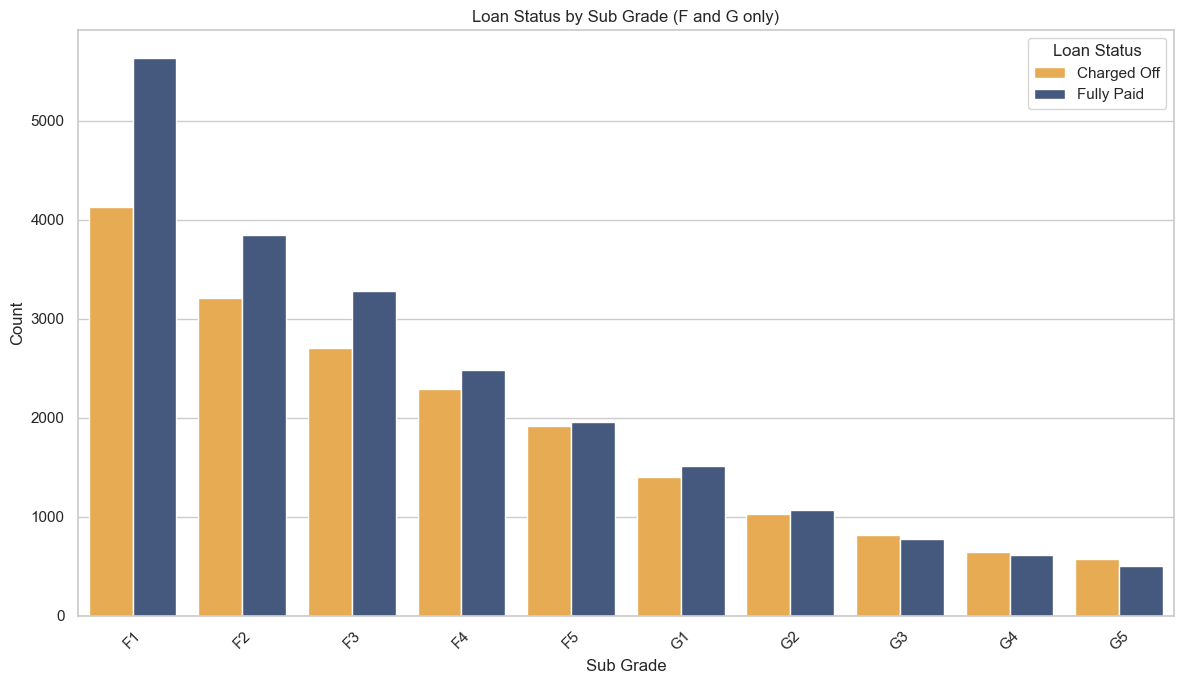

In [ ]:
# Group data to count loan status per sub_grade within Grades F and G
subgrade_counts = df_fg.groupby(['sub_grade', 'loan_status']).size().reset_index(name='count')

# Sort sub_grades alphabetically to preserve logical order (e.g., F1 to G5)
subgrade_order = sorted(df_fg['sub_grade'].unique())
subgrade_counts['sub_grade'] = pd.Categorical(
    subgrade_counts['sub_grade'],
    categories=subgrade_order,
    ordered=True
)
subgrade_counts = subgrade_counts.sort_values('sub_grade')

# Set visual style
sns.set(style="whitegrid")

# Set figure size (approx. 1000x600 pixels)
plt.figure(figsize=(12, 7))

# Create grouped bar chart
sns.barplot(
    data=subgrade_counts,
    x='sub_grade',
    y='count',
    hue='loan_status',
    palette={'Fully Paid': '#3c5587', 'Charged Off': '#ffaf3c'}
)

# Customize labels and title
plt.title('Loan Status by Sub Grade (F and G only)')
plt.xlabel('Sub Grade')
plt.ylabel('Count')
plt.legend(title='Loan Status')
plt.xticks(rotation=45)  # Rotate x-axis labels for readability

# Show the plot
plt.tight_layout()
plt.show()

## Home Ownership Value Counts

This command returns the count of loan applicants under each **home ownership** category, such as:
- **RENT**
- **OWN**
- **MORTGAGE**
- Possibly **OTHER** or **NONE**

This helps:
- Understand the distribution of borrowers by housing status.
- Determine how to encode or group categories for modeling.
- Assess if certain ownership types might influence default risk in further analysis.


In [23]:
# Count the number of occurrences for each home ownership category
filtered_df['home_ownership'].value_counts()

home_ownership
MORTGAGE    645496
RENT        517808
OWN         139844
ANY            267
OTHER          144
NONE            48
Name: count, dtype: int64

## Loan Status by Home Ownership

This grouped bar chart shows how **loan status** (*Fully Paid* vs *Charged Off*) varies across different **home ownership categories**, such as:
- **RENT**
- **OWN**
- **MORTGAGE**
- **OTHER**

**Purpose:**
- Explore if housing status affects repayment behavior.
- Identify whether certain categories are more prone to defaults.
- Inform risk assessment or model feature selection.

Clear differences in charge-off rates among ownership types may signal financial stability patterns.


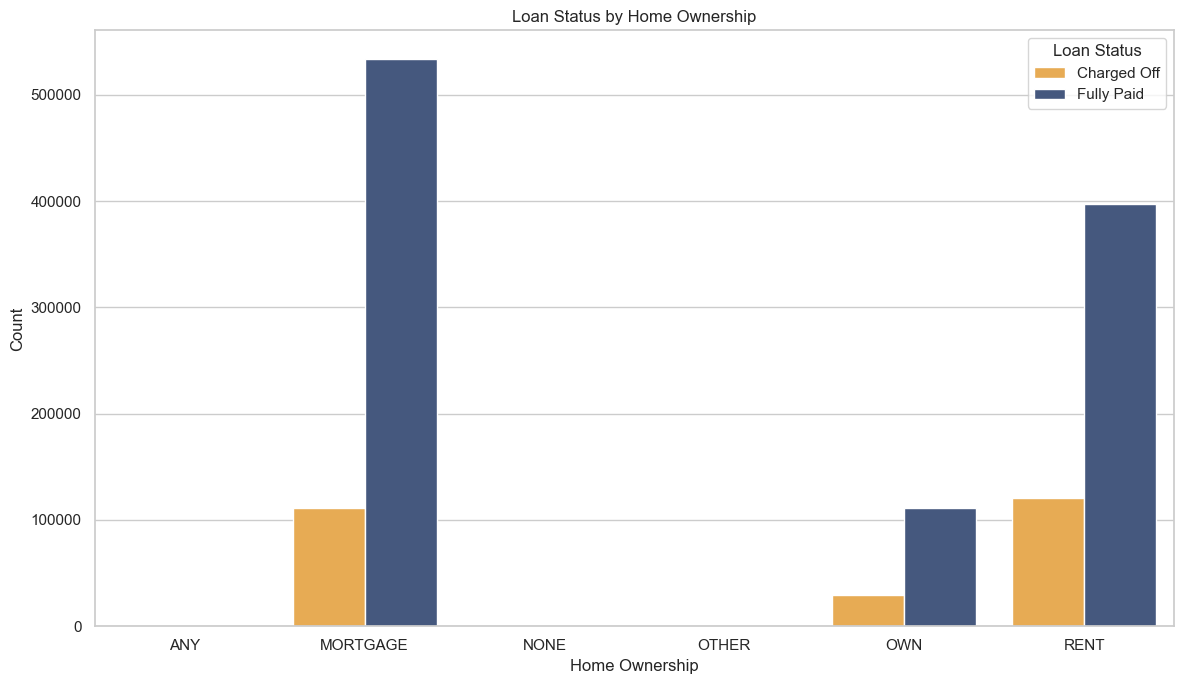

In [24]:
# Group and count the number of loans by home ownership type and loan status
home_ownership_counts = (
    filtered_df.groupby(['home_ownership', 'loan_status'])
    .size()
    .reset_index(name='count')
)

# Set the style
sns.set(style="whitegrid")

# Set figure size (approx. 1000x600 pixels)
plt.figure(figsize=(12, 7))

# Create grouped bar chart
sns.barplot(
    data=home_ownership_counts,
    x='home_ownership',
    y='count',
    hue='loan_status',
    palette={'Fully Paid': '#3c5587', 'Charged Off': '#ffaf3c'}
)

# Customize labels and title
plt.title('Loan Status by Home Ownership')
plt.xlabel('Home Ownership')
plt.ylabel('Count')
plt.legend(title='Loan Status')
plt.xticks(rotation=0)

# Display the plot
plt.tight_layout()
plt.show()

## Loan Status by Term

This grouped bar chart illustrates how loan outcomes (*Fully Paid* vs *Charged Off*) differ across loan **term durations**, typically:
- **36 months**
- **60 months**

**Purpose:**
- Assess if longer-term loans are more likely to result in default.
- Identify patterns in repayment behavior based on loan duration.
- Support lenders in balancing term offerings with risk mitigation.

This insight can help inform product design and underwriting policies.


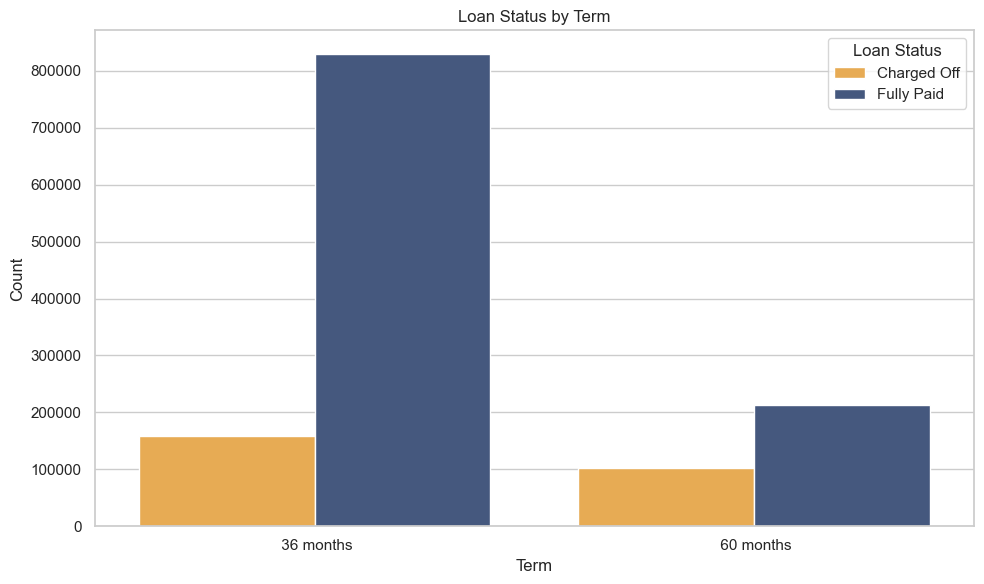

In [25]:
# Group and count the number of loans by term and loan status
term_counts = (
    filtered_df[filtered_df['loan_status'].isin(['Fully Paid', 'Charged Off'])]
    .groupby(['term', 'loan_status'])
    .size()
    .reset_index(name='count')
)

# Set style
sns.set(style="whitegrid")

# Set figure size
plt.figure(figsize=(10, 6))

# Create grouped bar chart
sns.barplot(
    data=term_counts,
    x='term',
    y='count',
    hue='loan_status',
    palette={'Fully Paid': '#3c5587', 'Charged Off': '#ffaf3c'}
)

# Customize title and axis labels
plt.title('Loan Status by Term')
plt.xlabel('Term')
plt.ylabel('Count')
plt.legend(title='Loan Status')
plt.xticks(rotation=0)

# Show plot
plt.tight_layout()
plt.show()


## Loan Status by Home Ownership

This grouped bar chart compares the number of loans that were **Fully Paid** vs **Charged Off** across different **home ownership categories**, such as:
- **RENT**
- **OWN**
- **MORTGAGE**
- **OTHER**

**Purpose:**
- To explore whether housing status is associated with loan performance.
- Identify if certain ownership types correlate with higher default rates.
- Provide insights that can support risk-based lending policies.

The comparison highlights borrower stability and financial reliability based on homeownership.


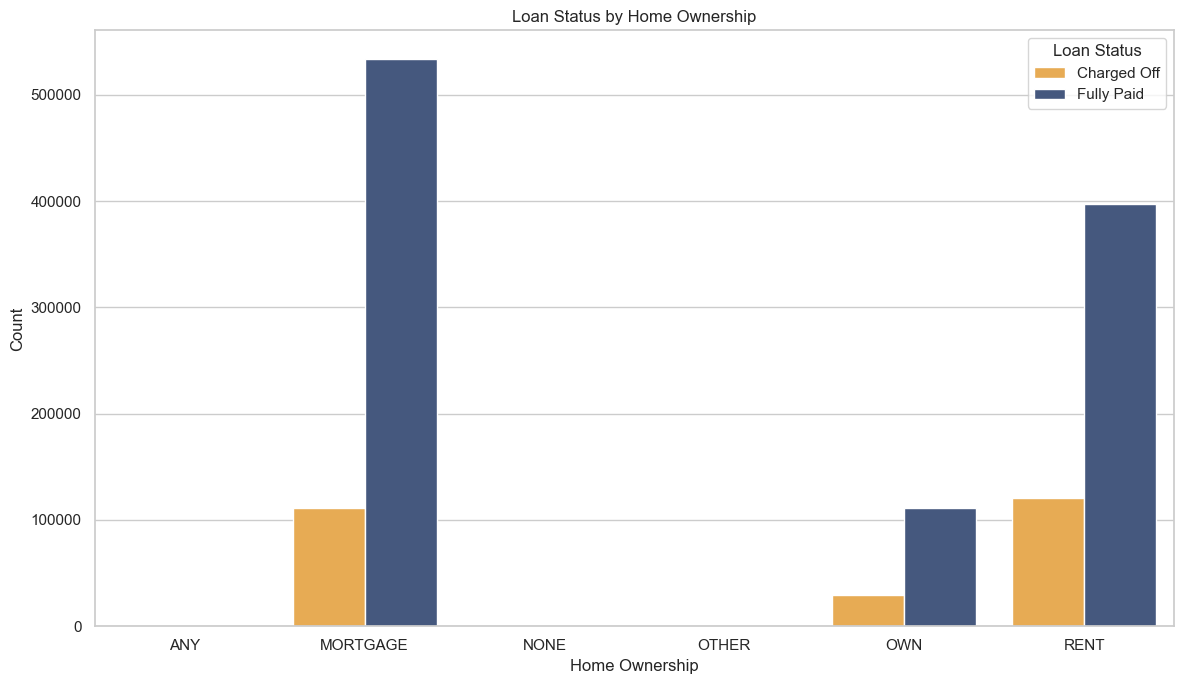

In [26]:
# Group and count loan status across different home ownership categories
home_ownership_counts = (
    filtered_df[filtered_df['loan_status'].isin(['Fully Paid', 'Charged Off'])]
    .groupby(['home_ownership', 'loan_status'])
    .size()
    .reset_index(name='count')
)

# Set the visual style
sns.set(style="whitegrid")

# Set the figure size
plt.figure(figsize=(12, 7))

# Create the grouped bar chart
sns.barplot(
    data=home_ownership_counts,
    x='home_ownership',
    y='count',
    hue='loan_status',
    palette={'Fully Paid': '#3c5587', 'Charged Off': '#ffaf3c'}
)

# Add title and axis labels
plt.title('Loan Status by Home Ownership')
plt.xlabel('Home Ownership')
plt.ylabel('Count')
plt.legend(title='Loan Status')
plt.xticks(rotation=0)

# Show the plot
plt.tight_layout()
plt.show()

## Loan Status by Verification Status

This grouped bar chart shows how loan outcomes (*Fully Paid* vs *Charged Off*) vary based on the **income verification status** of borrowers, including:
- **Not Verified**
- **Source Verified**
- **Verified**

**Purpose:**
- To determine if verified income is associated with better repayment behavior.
- To assess whether lenders should place greater emphasis on income verification.
- To reveal whether lack of verification correlates with higher default rates.

This feature is especially relevant for fraud prevention and creditworthiness assessment.


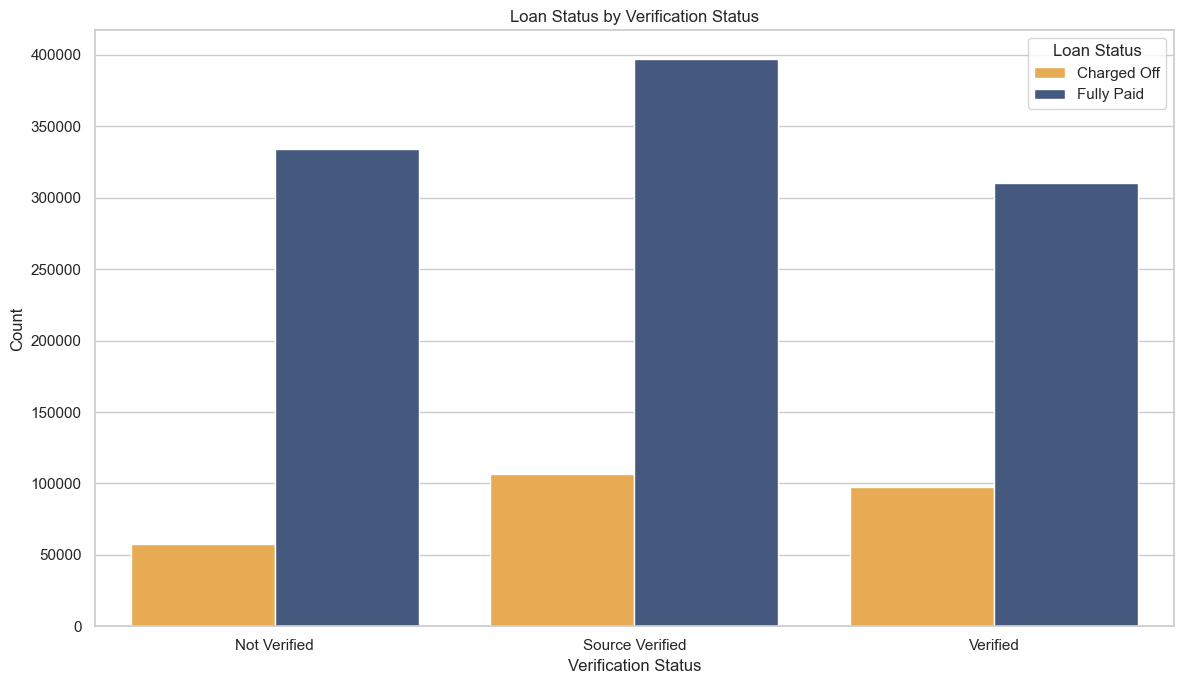

In [27]:
# Group and count loan status by verification status
verification_counts = (
    filtered_df[filtered_df['loan_status'].isin(['Fully Paid', 'Charged Off'])]
    .groupby(['verification_status', 'loan_status'])
    .size()
    .reset_index(name='count')
)

# Set the style
sns.set(style="whitegrid")

# Set the figure size
plt.figure(figsize=(12, 7))

# Create the grouped bar chart
sns.barplot(
    data=verification_counts,
    x='verification_status',
    y='count',
    hue='loan_status',
    palette={'Fully Paid': '#3c5587', 'Charged Off': '#ffaf3c'}
)

# Customize chart aesthetics
plt.title('Loan Status by Verification Status')
plt.xlabel('Verification Status')
plt.ylabel('Count')
plt.legend(title='Loan Status')
plt.xticks(rotation=0)

# Show the plot
plt.tight_layout()
plt.show()


## Loan Status by Purpose

This grouped bar chart visualizes how loan outcomes (*Fully Paid* vs *Charged Off*) differ based on the **purpose** for which the loan was taken, such as:
- **Debt Consolidation**
- **Credit Card**
- **Home Improvement**
- **Small Business**
- **Medical**
- And others

**Purpose of Analysis:**
- Identify loan purposes with higher default rates.
- Reveal riskier loan categories (e.g., *small business*, *medical*).
- Inform lenders on which purposes may require stricter evaluation or underwriting.

This analysis is key for segmenting borrower risk by intent.


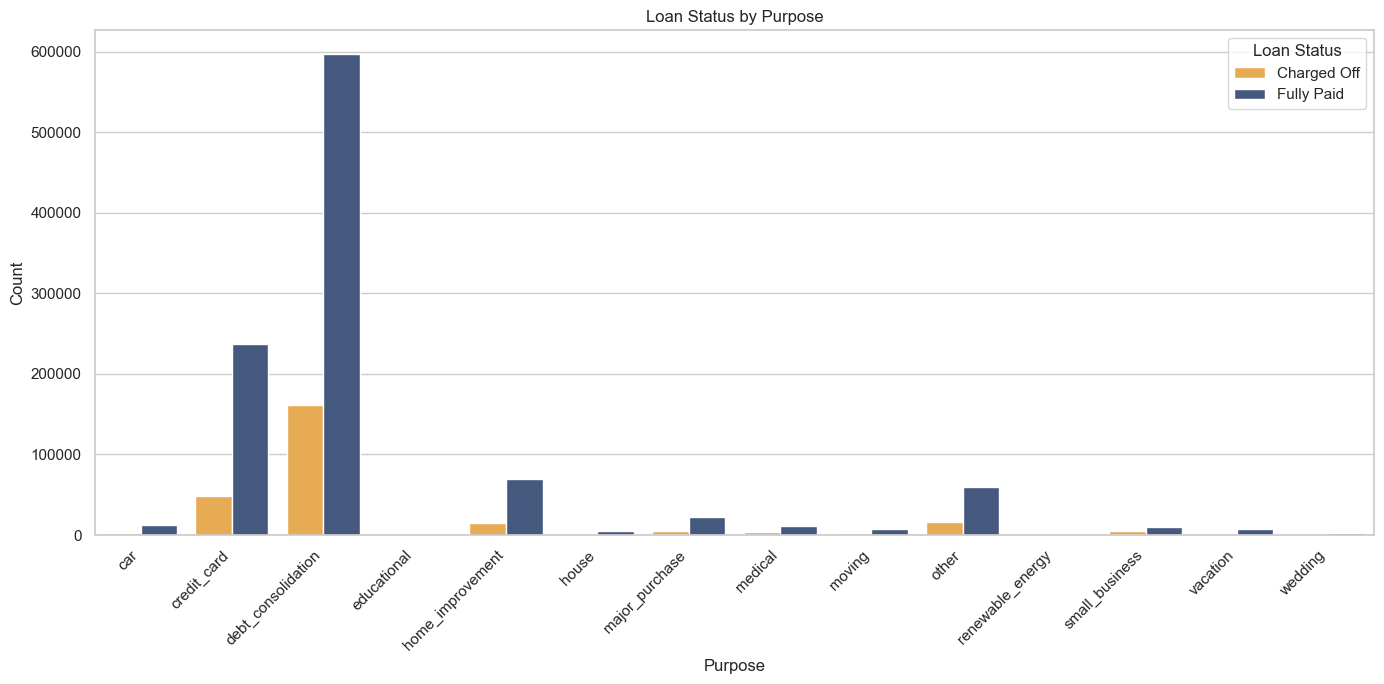

In [28]:
# Group and count loans by loan purpose and loan status
purpose_counts = (
    filtered_df[filtered_df['loan_status'].isin(['Fully Paid', 'Charged Off'])]
    .groupby(['purpose', 'loan_status'])
    .size()
    .reset_index(name='count')
)

# Set the visual style
sns.set(style="whitegrid")

# Set the figure size
plt.figure(figsize=(14, 7))  # Wider to accommodate rotated labels

# Create the grouped bar chart
sns.barplot(
    data=purpose_counts,
    x='purpose',
    y='count',
    hue='loan_status',
    palette={'Fully Paid': '#3c5587', 'Charged Off': '#ffaf3c'}
)

# Customize chart labels and title
plt.title('Loan Status by Purpose')
plt.xlabel('Purpose')
plt.ylabel('Count')
plt.legend(title='Loan Status')
plt.xticks(rotation=45, ha='right')  # Rotate labels for readability

# Show the plot
plt.tight_layout()
plt.show()

## Loan Status by Interest Rate

This overlaid histogram shows the distribution of **interest rates** for loans that were either *Fully Paid* or *Charged Off*.

**Purpose:**
- Understand how interest rates vary with loan outcomes.
- Explore if higher interest rates correlate with increased charge-off risk.
- Visualize risk-pricing relationships in the loan portfolio.

Typically, riskier borrowers receive higher interest rates, so this chart can highlight how well pricing aligns with risk.


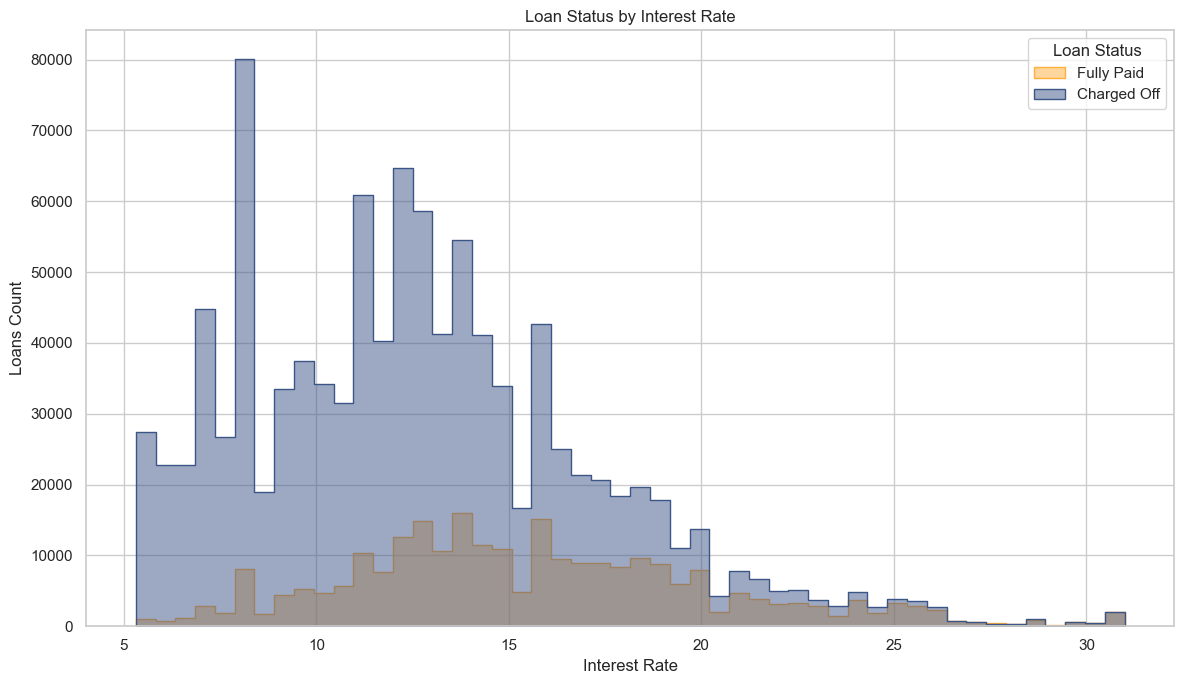

In [47]:
# Create an overlaid histogram to visualize interest rate distribution by loan status
sns.set(style="whitegrid")

# Set the figure size (approx. 1000x600 pixels)
plt.figure(figsize=(12, 7))

# Create an overlaid histogram
sns.histplot(
    data=filtered_df,
    x='int_rate',
    hue='loan_status',
    bins=50,
    element='step',  # Use 'step' for overlay effect
    stat='count',
    common_norm=False,  # Use raw counts
    palette={'Fully Paid': '#3c5587', 'Charged Off': '#ffaf3c'},
    alpha=0.5
)

# Customize labels and title
plt.title('Loan Status by Interest Rate')
plt.xlabel('Interest Rate')
plt.ylabel('Loans Count')

# Force a legend to appear even if Seaborn skips it
handles, labels = ax.get_legend_handles_labels()
if handles:
    plt.legend(handles=handles, labels=labels, title='Loan Status')
else:
    plt.legend(['Fully Paid', 'Charged Off'], title='Loan Status')

# Show the plot
plt.tight_layout()
plt.show()


## Loan Status by Annual Income

This overlaid histogram shows the distribution of **annual income** for borrowers who either *Fully Paid* or *Charged Off* their loans.

**Why it matters:**
- Helps assess whether income levels influence repayment behavior.
- Reveals whether lower-income borrowers are more likely to default.
- Identifies if income thresholds could be used for risk segmentation.

This visualization supports evaluating borrower capacity and setting income-based lending criteria.


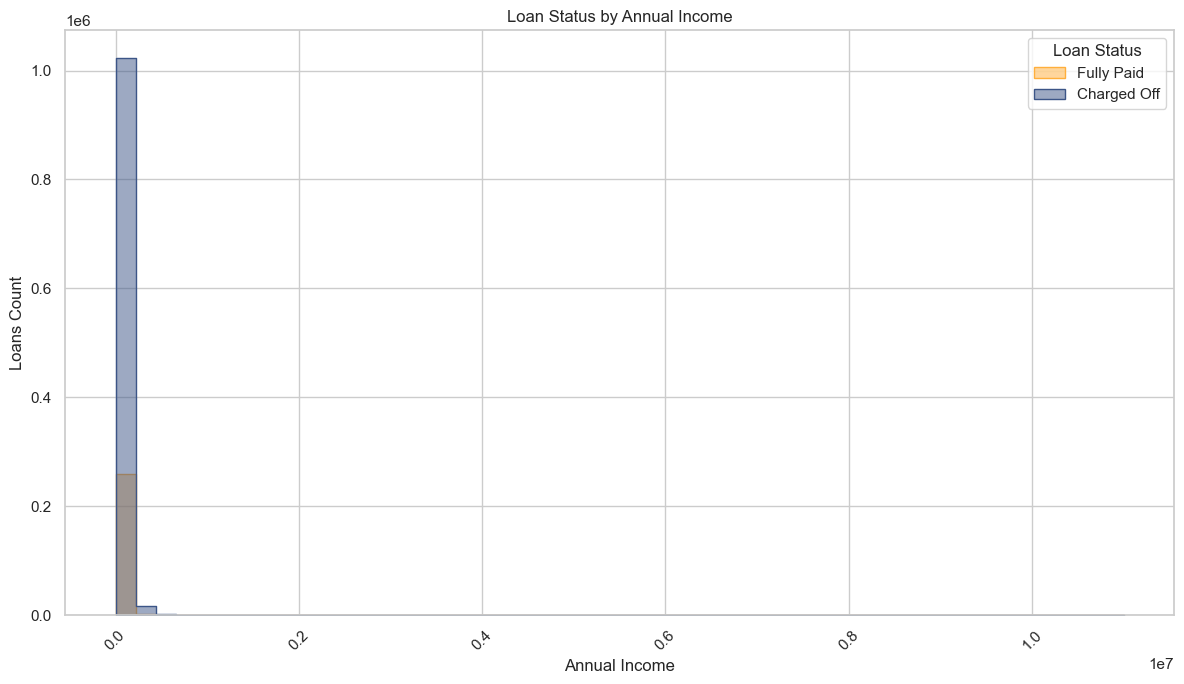

In [48]:
# Create an overlaid histogram to visualize annual income distribution by loan status
sns.set(style="whitegrid")
plt.figure(figsize=(12, 7))

# Create histogram
sns.histplot(
    data=filtered_df,
    x='annual_inc',
    hue='loan_status',
    bins=50,
    element='step',  # Use 'step' for overlaid appearance
    stat='count',
    common_norm=False,  # Keep actual counts
    palette={'Fully Paid': '#3c5587', 'Charged Off': '#ffaf3c'},
    alpha=0.5
)

# Set title and labels
plt.title('Loan Status by Annual Income')
plt.xlabel('Annual Income')
plt.ylabel('Loans Count')
# Force a legend to appear even if Seaborn skips it
handles, labels = ax.get_legend_handles_labels()
if handles:
    plt.legend(handles=handles, labels=labels, title='Loan Status')
else:
    plt.legend(['Fully Paid', 'Charged Off'], title='Loan Status')

# Rotate x-axis labels
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()

## Loan Status by Annual Income (Capped at $250,000)

To reduce skew from extreme outliers, this histogram shows loan status distribution for borrowers earning **$250,000/year or less**.

**Purpose:**
- Focus on the core borrower population for more accurate analysis.
- Visualize the relationship between moderate income levels and loan performance.
- Reduce distortion in patterns caused by very high-income borrowers.

This filtered view provides a clearer understanding of income-related default trends in the majority segment.


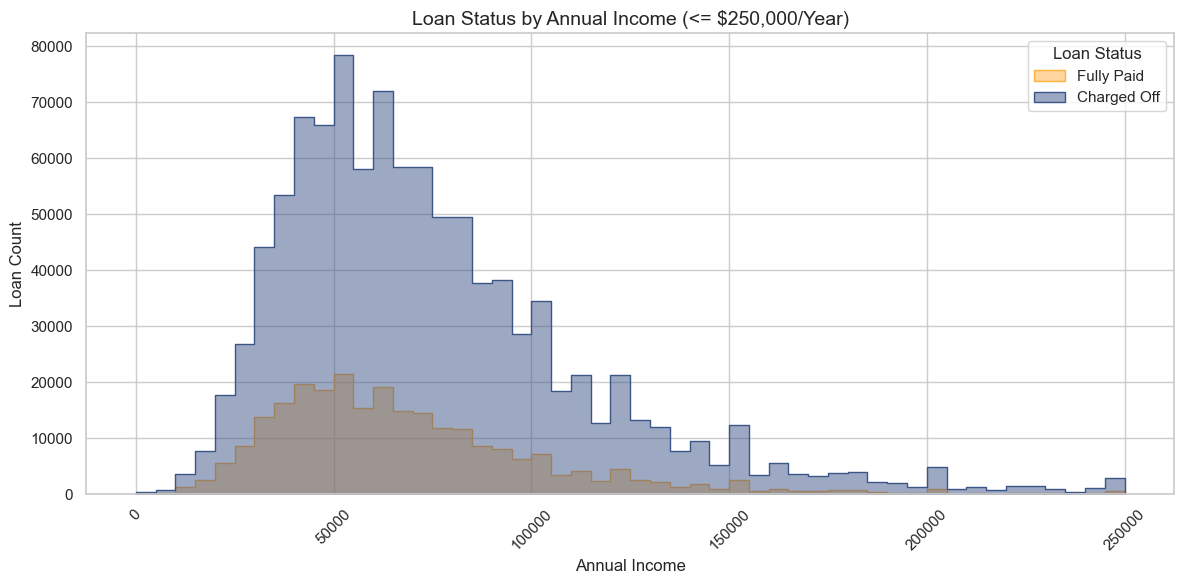

In [49]:
# Filter dataset to remove outliers and focus on borrowers with income <= $250,000
filtered_income_df = filtered_df[filtered_df['annual_inc'] <= 250000]

# Create overlaid histogram to show loan status by annual income (capped at $250K)
sns.set(style="whitegrid")

# Set figure size
plt.figure(figsize=(12, 6))

# Plot histogram with seaborn
sns.histplot(
    data=filtered_income_df,
    x='annual_inc',
    hue='loan_status',
    bins=50,
    element='step',
    stat='count',
    common_norm=False,
    palette={'Fully Paid': '#3c5587', 'Charged Off': '#ffaf3c'},
    alpha=0.5
)

# Set title and labels
plt.title("Loan Status by Annual Income (<= $250,000/Year)", fontsize=14)
plt.xlabel("Annual Income", fontsize=12)
plt.ylabel("Loan Count", fontsize=12)
plt.xticks(rotation=45)
# Force a legend to appear even if Seaborn skips it
handles, labels = ax.get_legend_handles_labels()
if handles:
    plt.legend(handles=handles, labels=labels, title='Loan Status')
else:
    plt.legend(['Fully Paid', 'Charged Off'], title='Loan Status')

# Show the plot
plt.tight_layout()
plt.show()

## Loan Status for High-Income Borrowers (≥ $1,000,000 Annual Income)

This command filters the dataset to include only borrowers with **annual income of $1,000,000 or more**, and then counts how many of them:
- Fully Paid their loans
- Were Charged Off

**Purpose:**
- To examine loan performance among ultra high-income individuals.
- To test if high income guarantees lower default risk.
- To identify whether wealthy applicants pose unique risk patterns.

This insight is useful for understanding the behavior of outliers in income-based segmentation.


In [32]:
# Check how many loans were Fully Paid vs Charged Off among borrowers earning $1,000,000 or more
filtered_df.loc[filtered_df.annual_inc >= 1000000, 'loan_status'].value_counts()

loan_status
Fully Paid     282
Charged Off     43
Name: count, dtype: int64

## Loan Status for High-Income Borrowers (≥ $250,000 Annual Income)

This query filters the dataset for borrowers earning **$250,000 or more annually** and counts the number of loans that were:
- **Fully Paid**
- **Charged Off**

**Purpose:**
- To analyze whether higher-income borrowers tend to default less.
- To assess loan performance among affluent individuals.
- To evaluate if income alone is a reliable indicator of repayment behavior.

This can help shape income-based credit policies and risk thresholds.


In [33]:
# Count loan outcomes for borrowers earning $250,000 or more annually
filtered_df.loc[filtered_df.annual_inc >= 250000, 'loan_status'].value_counts()

loan_status
Fully Paid     13589
Charged Off     2145
Name: count, dtype: int64

## DTI (Debt-to-Income) Value Counts

This command returns the frequency of each unique **Debt-to-Income (DTI)** ratio in the dataset.

**Purpose:**
- Understand how DTI values are distributed.
- Identify any dominant or common DTI levels among borrowers.
- Spot unusually repeated or potentially imputed values.

DTI is a key financial indicator used to assess a borrower's ability to manage debt relative to income.


In [34]:
# Display the count of each unique Debt-to-Income (DTI) ratio value in the dataset
filtered_df.dti.value_counts()

dti
18.00     961
19.20     953
14.40     932
16.80     923
13.20     890
         ... 
79.09       1
52.25       1
51.65       1
52.51       1
231.01      1
Name: count, Length: 6870, dtype: int64

## Debt-to-Income (DTI) Distribution

This histogram visualizes the distribution of **Debt-to-Income (DTI)** ratios across all borrowers.

**Purpose:**
- To explore how borrower debt loads compare to their incomes.
- Identify typical and extreme DTI values.
- Assess the need for scaling or outlier handling during preprocessing.

DTI is a key feature in determining creditworthiness, as high ratios may indicate financial stress.


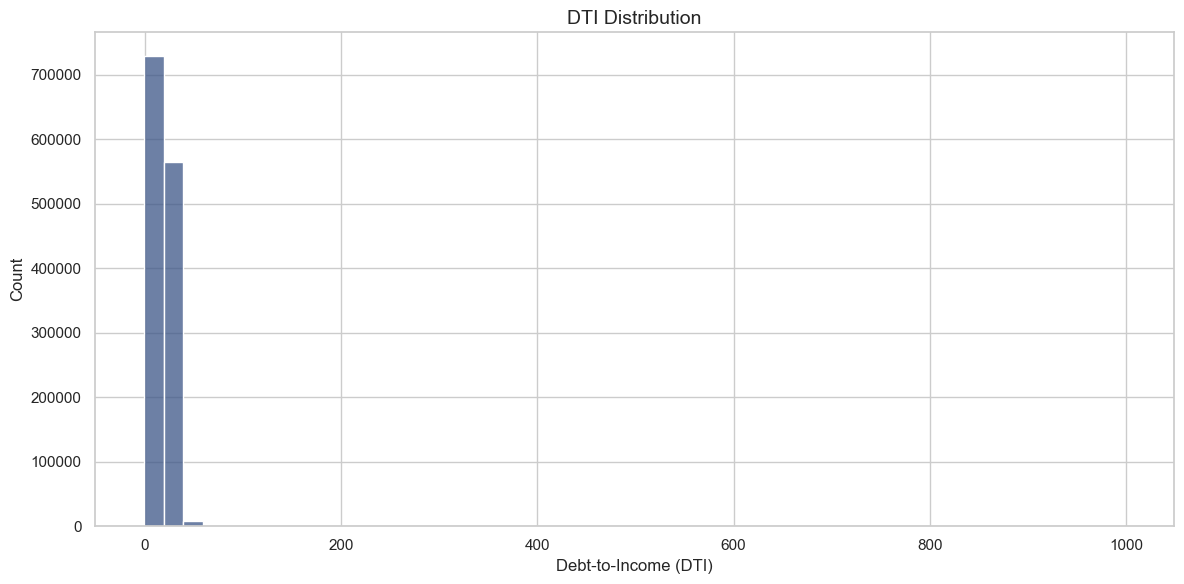

In [ ]:
# Create a histogram to show the distribution of Debt-to-Income (DTI) ratios
sns.set(style="whitegrid")

# Set figure size
plt.figure(figsize=(12, 6))

# Plot histogram
sns.histplot(
    data=filtered_df,
    x='dti',
    bins=50,
    color='#3c5587'
)

# Set plot titles and labels
plt.title("DTI Distribution", fontsize=14)
plt.xlabel("Debt-to-Income (DTI)", fontsize=12)
plt.ylabel("Count", fontsize=12)

# Show plot
plt.tight_layout()
plt.show()

## DTI Distribution (Filtered to ≤ 50)

This histogram focuses on borrowers with a **Debt-to-Income (DTI)** ratio of **50 or less**, excluding extreme outliers.

**Purpose:**
- To better understand the DTI distribution in the general borrower population.
- Reduce the impact of a few high-DTI outliers that skew the full distribution.
- Assist in identifying normal operating ranges for model input scaling.

Filtering enhances interpretability and avoids misleading impressions caused by outliers.


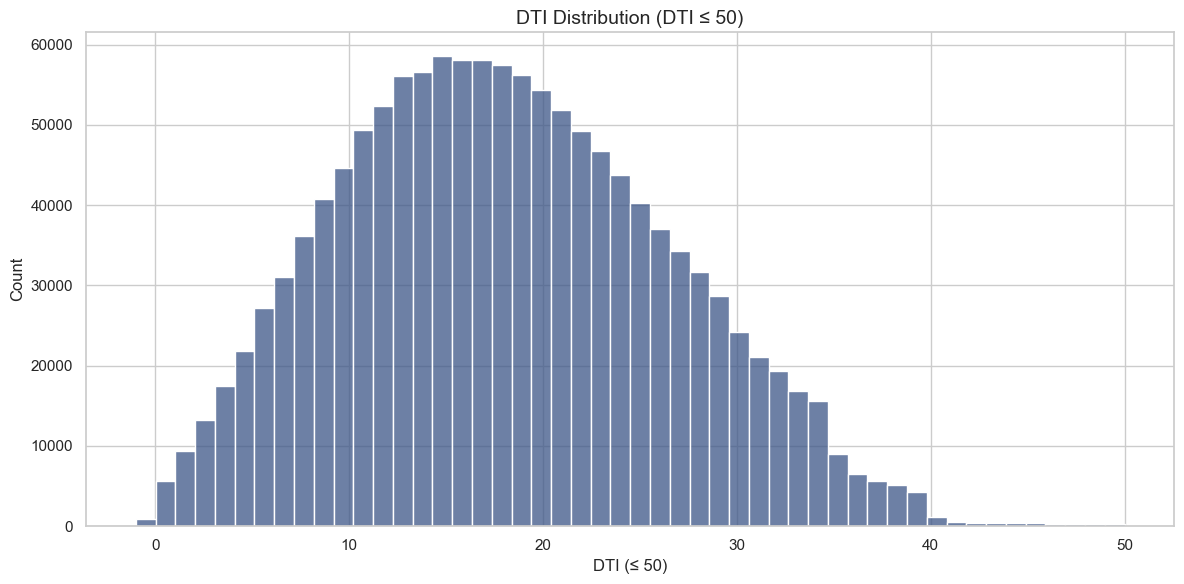

In [ ]:
# Create a histogram showing DTI distribution for borrowers with DTI ≤ 50
filtered_dti_df = filtered_df[filtered_df['dti'] <= 50]

# Set seaborn style
sns.set(style="whitegrid")

# Set figure size
plt.figure(figsize=(12, 6))

# Plot histogram
sns.histplot(
    data=filtered_dti_df,
    x='dti',
    bins=50,
    color='#3c5587'
)

# Customize titles and labels
plt.title("DTI Distribution (DTI ≤ 50)", fontsize=14)
plt.xlabel("DTI (≤ 50)", fontsize=12)
plt.ylabel("Count", fontsize=12)

# Display the plot
plt.tight_layout()
plt.show()


## Borrowers with High DTI (≥ 40)

This command returns the shape (number of rows and columns) of the dataset subset where borrowers have a **Debt-to-Income (DTI) ratio of 40 or higher**.

**Purpose:**
- Identify how many high-risk borrowers exist based on DTI.
- Assess the portion of the dataset that may be more financially stressed.
- Inform strategies for risk segmentation or exclusion during modeling.

This metric helps evaluate whether high DTI thresholds are common and require special attention.


In [37]:
# Print the number of rows and columns for borrowers with DTI ≥ 40
print(filtered_df[filtered_df['dti'] >= 40].shape)

(6101, 17)


## Loan Status for Borrowers with DTI ≥ 50

This command filters the dataset to include only those borrowers with a **Debt-to-Income (DTI) ratio of 50 or more**, and then counts how many:
- **Fully Paid** their loans
- Were **Charged Off**

**Purpose:**
- To assess loan performance for borrowers under extreme debt stress.
- Determine whether high DTI is a strong indicator of loan default.
- Provide data-driven justification for risk thresholds in credit decision-making.

This insight is critical for identifying financially over-leveraged applicants.


In [38]:
# Count the loan outcomes for borrowers with DTI ≥ 50
filtered_df.loc[filtered_df['dti'] >= 50, 'loan_status'].value_counts()

loan_status
Fully Paid     1776
Charged Off     716
Name: count, dtype: int64

## DTI (≤ 50) Distribution by Loan Status

This histogram shows how **Debt-to-Income (DTI) ratios** up to 50 are distributed among borrowers who either:
- Fully Paid their loans
- Were Charged Off

**Purpose:**
- Compare DTI distributions across loan outcomes.
- Identify if higher DTI (within reasonable range) correlates with more defaults.
- Understand borrower financial load in relation to risk.

Overlaying both loan statuses helps visualize how financial stress may contribute to loan performance differences.


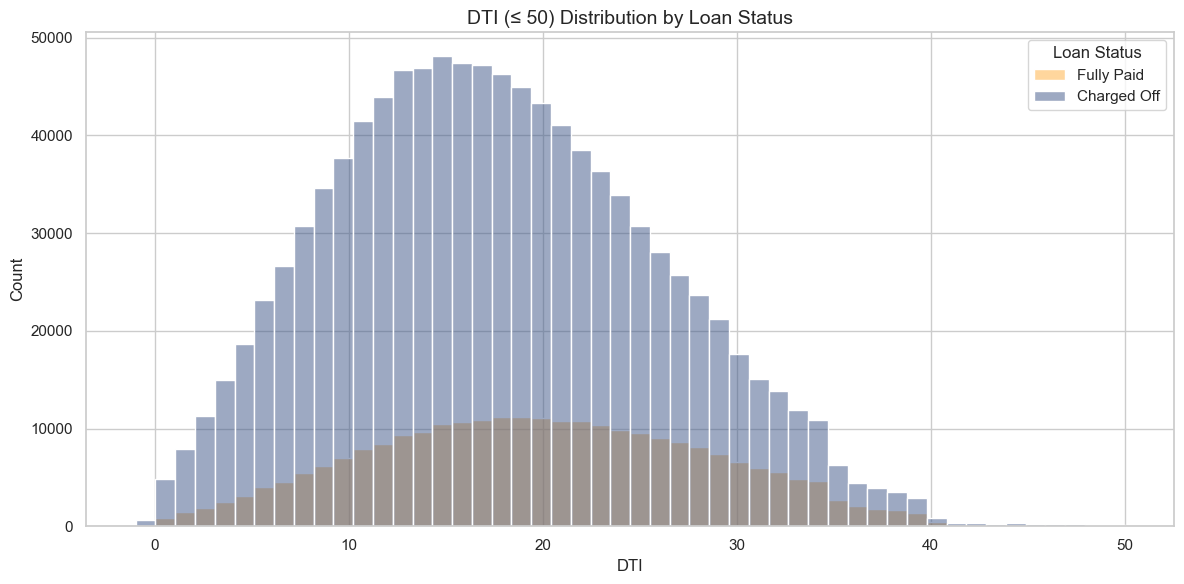

In [50]:
# Create a histogram to show the distribution of DTI ≤ 50, colored by loan status
sns.set(style="whitegrid")

# Set figure size
plt.figure(figsize=(12, 6))

# Plot histogram with hue for loan_status
sns.histplot(
    data=filtered_dti_df,
    x='dti',
    hue='loan_status',
    bins=50,
    kde=False,
    multiple='layer',  # Overlay bars
    palette={
        'Fully Paid': '#3c5587',
        'Charged Off': '#ffaf3c'
    },
    alpha=0.5
)

# Customize titles and labels
plt.title("DTI (≤ 50) Distribution by Loan Status", fontsize=14)
plt.xlabel("DTI", fontsize=12)
plt.ylabel("Count", fontsize=12)

# Force a legend to appear even if Seaborn skips it
handles, labels = ax.get_legend_handles_labels()
if handles:
    plt.legend(handles=handles, labels=labels, title='Loan Status')
else:
    plt.legend(['Fully Paid', 'Charged Off'], title='Loan Status')

# Show plot
plt.tight_layout()
plt.show()

## Loan Status by the Number of Open Credit Lines

This histogram illustrates how the **number of open credit lines** varies between borrowers who:
- Fully Paid their loans
- Were Charged Off

**Purpose:**
- Assess whether having many open accounts correlates with higher or lower default risk.
- Understand if open credit activity influences repayment behavior.
- Identify typical credit activity among both reliable and risky borrowers.

This feature reflects how actively borrowers use credit and may indicate financial health or overextension.


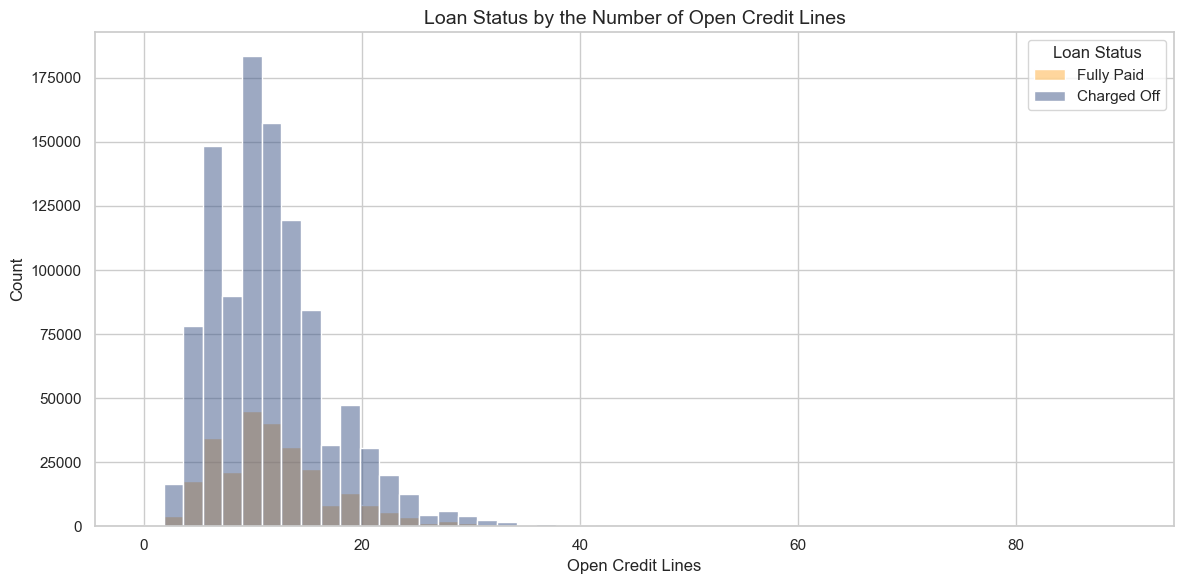

In [51]:
# Create a histogram to visualize the number of open credit lines by loan status
sns.set(style="whitegrid")

# Create figure
plt.figure(figsize=(12, 6))

# Plot histogram with hue = loan_status
sns.histplot(
    data=filtered_df,
    x='open_acc',
    hue='loan_status',
    bins=50,
    multiple='layer',  # Overlapping bars
    palette={
        'Fully Paid': '#3c5587',
        'Charged Off': '#ffaf3c'
    },
    alpha=0.5,
    legend='full'
)

# Set titles and labels
plt.title("Loan Status by the Number of Open Credit Lines", fontsize=14)
plt.xlabel("Open Credit Lines", fontsize=12)
plt.ylabel("Count", fontsize=12)
# Force a legend to appear even if Seaborn skips it
handles, labels = ax.get_legend_handles_labels()
if handles:
    plt.legend(handles=handles, labels=labels, title='Loan Status')
else:
    plt.legend(['Fully Paid', 'Charged Off'], title='Loan Status')

# Show the plot
plt.tight_layout()
plt.show()

## Number of Borrowers with Open Credit Lines > 40

This command checks how many borrowers have more than **40 open credit lines**, which could be considered unusually high.

**Purpose:**
- Detect outliers in the `open_acc` feature.
- Understand how common extreme credit usage is.
- Inform decisions about capping or treating such values during preprocessing.

Excessive open credit lines might signal either financial strength or overextension, depending on context.


In [52]:
# Print the number of records where the number of open credit lines exceeds 40
print(filtered_df[filtered_df.open_acc > 40].shape)

(1167, 17)


## Loan Status by Application Type

This grouped bar chart compares the distribution of loan outcomes (*Fully Paid* vs *Charged Off*) across different **application types**, such as:
- **Individual**
- **Joint Application**

**Purpose:**
- Identify whether joint applications result in fewer defaults.
- Explore if combining incomes or credit histories influences loan performance.
- Support risk-based policies for different applicant profiles.

This chart helps assess whether joint applications offer any credit advantage in terms of default risk.


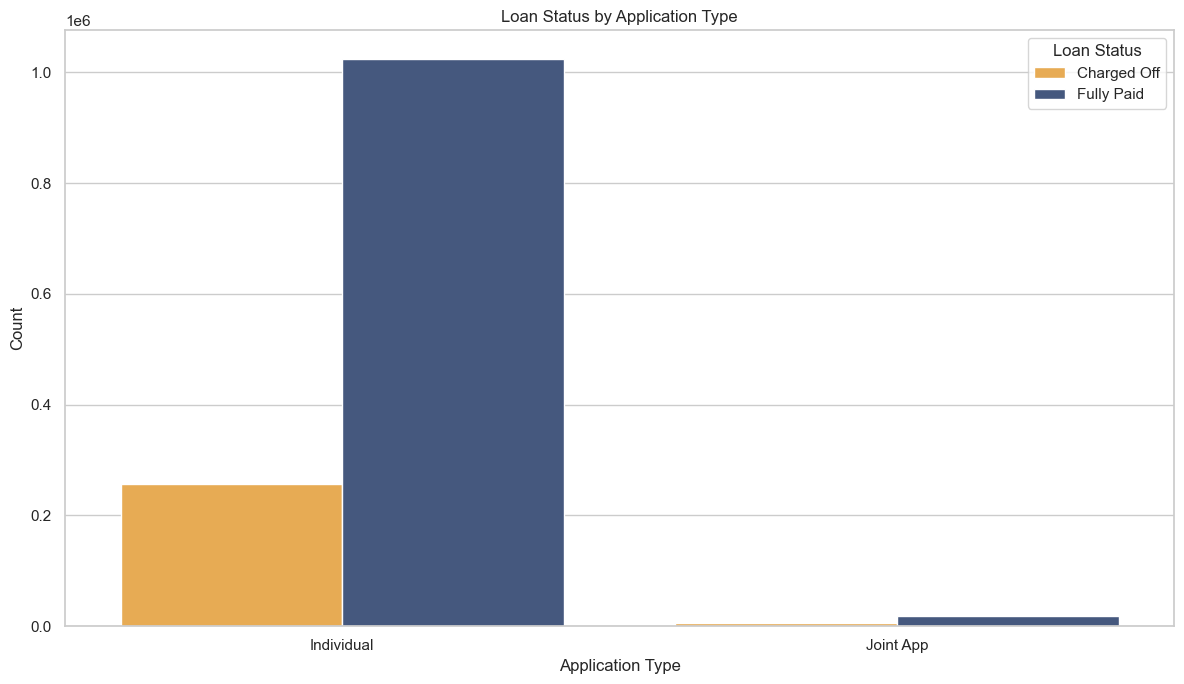

In [53]:
# Group and count application types by loan status
app_type_counts = filtered_df[filtered_df['loan_status'].isin(['Fully Paid', 'Charged Off'])] \
    .groupby(['application_type', 'loan_status']) \
    .size().reset_index(name='count')

sns.set(style="whitegrid")

# Create the figure
plt.figure(figsize=(12, 7))  # Width=1000px, Height=600px

# Plot the grouped bar chart
sns.barplot(
    data=app_type_counts,
    x='application_type',
    y='count',
    hue='loan_status',
    palette={'Fully Paid': '#3c5587', 'Charged Off': '#ffaf3c'}
)

# Set titles and labels
plt.title("Loan Status by Application Type")
plt.xlabel("Application Type")
plt.ylabel("Count")
plt.legend(title="Loan Status")

# Show the plot
plt.tight_layout()
plt.show()

## Loan Status by Number of Open Credit Lines

This analysis focuses on identifying borrowers with an unusually high number of **open credit lines** (i.e., more than 40), which may indicate increased credit activity or risk.

**Purpose:**
- Detect outliers or extreme cases in credit usage behavior.
- Understand the credit profile of borrowers with 40+ open accounts.
- Support risk assessment by highlighting potential over-leveraging.

This filtering helps financial analysts flag profiles that may require deeper scrutiny during the credit evaluation process.


In [54]:
# Print the number of records where the number of open credit lines exceeds 40
print(filtered_df[filtered_df.open_acc > 40].shape)

(1167, 17)


## Correlation between Loan Status and Numerical Features

This horizontal bar chart visualizes the **correlation** between the **loan status** and various **numerical features** in the dataset. Loan status is encoded as:
- `0` for **Fully Paid**
- `1` for **Charged Off**

**Purpose:**
- Identify which numerical variables are most strongly associated with loan default.
- Highlight features that have a positive or negative relationship with loan performance.
- Support feature selection for predictive modeling and risk analysis.

By ranking features based on correlation strength, this chart helps prioritize variables for further analysis or inclusion in machine learning models related to credit risk.


C:\Users\Ak\AppData\Local\Temp\ipykernel_9504\3364907935.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\Ak\AppData\Local\Temp\ipykernel_9504\3364907935.py:20: UserWarning: 
The palette list has fewer values (6) than needed (7) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(


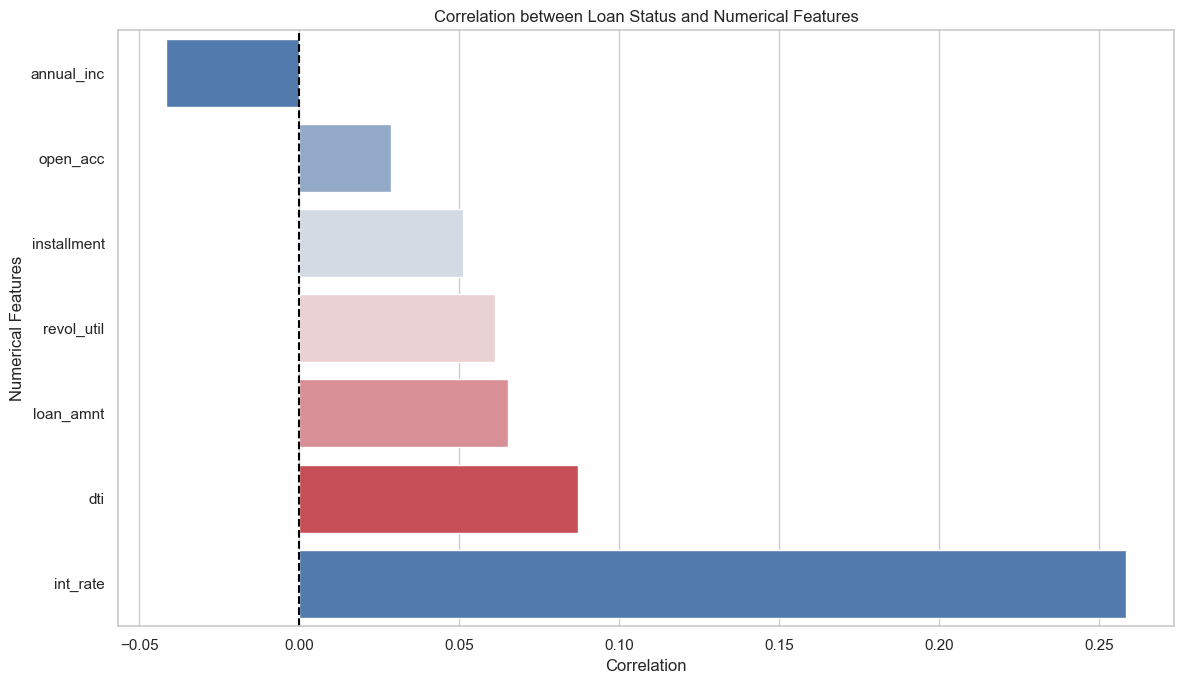

In [56]:
# Encode loan status: Fully Paid as 0, Charged Off as 1
filtered_df['loan_status_encoded'] = filtered_df['loan_status'].map({'Fully Paid': 0, 'Charged Off': 1})

# Select only numerical columns (excluding encoded loan status)
numeric_cols = filtered_df.select_dtypes(include=['number']).columns.drop('loan_status_encoded')

# Compute correlation of each numerical feature with the encoded loan status
correlation_series = filtered_df[numeric_cols].corrwith(filtered_df['loan_status_encoded'])

# Convert the correlation results to a DataFrame and sort
corr_df = correlation_series.reset_index()
corr_df.columns = ['feature', 'correlation']
corr_df = corr_df.sort_values(by='correlation')

# Set Seaborn style
sns.set(style="whitegrid")

# Create horizontal bar plot
plt.figure(figsize=(12, 7))
sns.barplot(
    data=corr_df,
    x='correlation',
    y='feature',
    palette=sns.diverging_palette(250, 10, as_cmap=False)
)

# Add labels and title
plt.title('Correlation between Loan Status and Numerical Features')
plt.xlabel('Correlation')
plt.ylabel('Numerical Features')
plt.axvline(x=0, color='black', linestyle='--')

plt.tight_layout()
plt.show()


## Analysis of Employment Title Column

These two lines of code help evaluate the **'emp_title'** column in terms of data completeness and variety.

**Purpose:**
- `isna().sum()` identifies how many records are missing a job title.
- `nunique()` reveals the number of unique employment titles provided by borrowers.

This analysis helps assess the need for data cleaning or grouping of similar job titles, especially when used in modeling or profiling.


In [57]:
# Print the number of missing (NaN) values in the 'emp_title' column
print(f"Number of missing values in 'emp_title': {filtered_df.emp_title.isna().sum()}")

# Print the number of unique job titles in the 'emp_title' column
print(f"Number of unique job titles in 'emp_title': {filtered_df.emp_title.nunique()}")

Number of missing values in 'emp_title': 82579
Number of unique job titles in 'emp_title': 371435


## Top 20 Most Common Employment Titles

This code identifies and prints the **top 20 most frequent job titles** in the `emp_title` column of the dataset.

**Purpose:**
- Understand which professions are most commonly represented among loan applicants.
- Provide insight into borrower occupation trends.
- Support grouping or categorization strategies for occupation-related analysis.

This analysis is useful for building borrower profiles or exploring correlations between job type and loan outcomes.


In [58]:
# Display the top 20 most frequent job titles in the 'emp_title' column
top_20_titles = filtered_df['emp_title'].value_counts()[:20]
print(top_20_titles)

emp_title
Teacher               20496
Manager               18704
Owner                  9803
Registered Nurse       8477
RN                     8253
Supervisor             8012
Driver                 7230
Sales                  7213
Project Manager        6154
Office Manager         5345
General Manager        5013
Director               4861
owner                  4405
manager                4378
Engineer               4134
President              3992
teacher                3954
Vice President         3414
driver                 3403
Operations Manager     3342
Name: count, dtype: int64


## Loan Status by Employment Length

This grouped histogram visualizes how loan status (*Fully Paid* vs *Charged Off*) varies across different **employment lengths**, ranging from "< 1 year" to "10+ years".

**Purpose:**
- Analyze whether borrowers with longer employment history have better loan repayment behavior.
- Explore if employment stability correlates with reduced loan default risk.
- Assist in designing risk models based on borrower employment profiles.

This chart helps determine whether employment duration plays a role in loan outcomes and supports data-driven credit policy decisions.


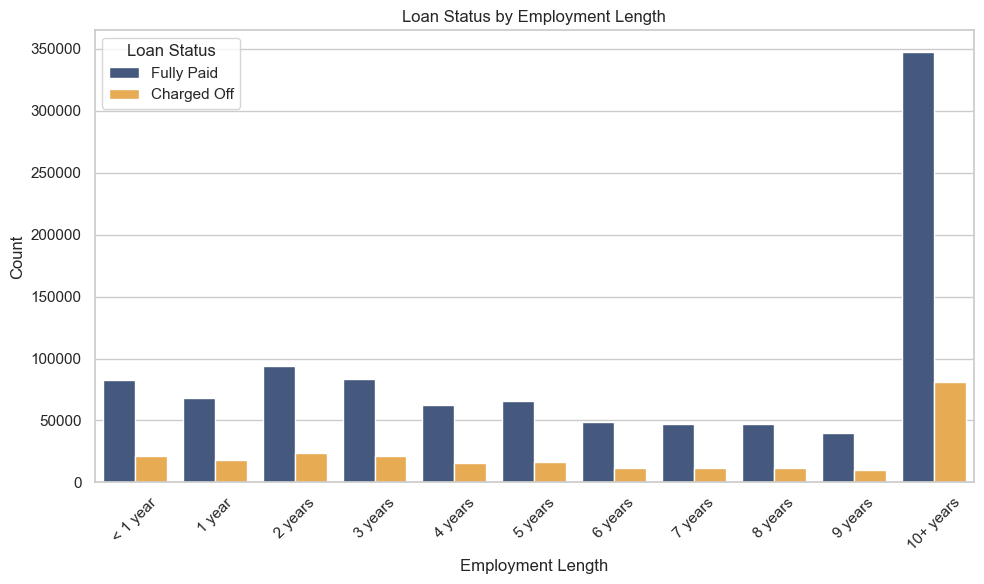

In [59]:
# Define the custom order for employment length categories
emp_order = ['< 1 year', '1 year', '2 years', '3 years', '4 years',
             '5 years', '6 years', '7 years', '8 years', '9 years', '10+ years']

# Convert 'emp_length' to an ordered categorical type
filtered_df['emp_length'] = pd.Categorical(filtered_df['emp_length'], categories=emp_order, ordered=True)

# Set seaborn style
sns.set(style='whitegrid')

# Create the grouped bar chart
plt.figure(figsize=(10, 6))  # Width=800px, Height=500px approx
sns.countplot(
    data=filtered_df,
    x='emp_length',
    hue='loan_status',
    order=emp_order,
    palette={'Fully Paid': '#3c5587', 'Charged Off': '#ffaf3c'}
)

# Customize plot elements
plt.title('Loan Status by Employment Length')
plt.xlabel('Employment Length')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Loan Status')

# Adjust layout to fit elements
plt.tight_layout()
plt.show()

## The Most 30 Job Titles That Afforded a Loan

This horizontal bar chart displays the **top 30 most frequent job titles** among borrowers who were granted loans.

**Purpose:**
- Identify which professions are most represented in the loan applicant pool.
- Understand the occupational background of borrowers.
- Inform segmentation strategies or credit risk assessments based on employment type.

By focusing on the most common job titles, this chart provides insights into the professional landscape of loan recipients.


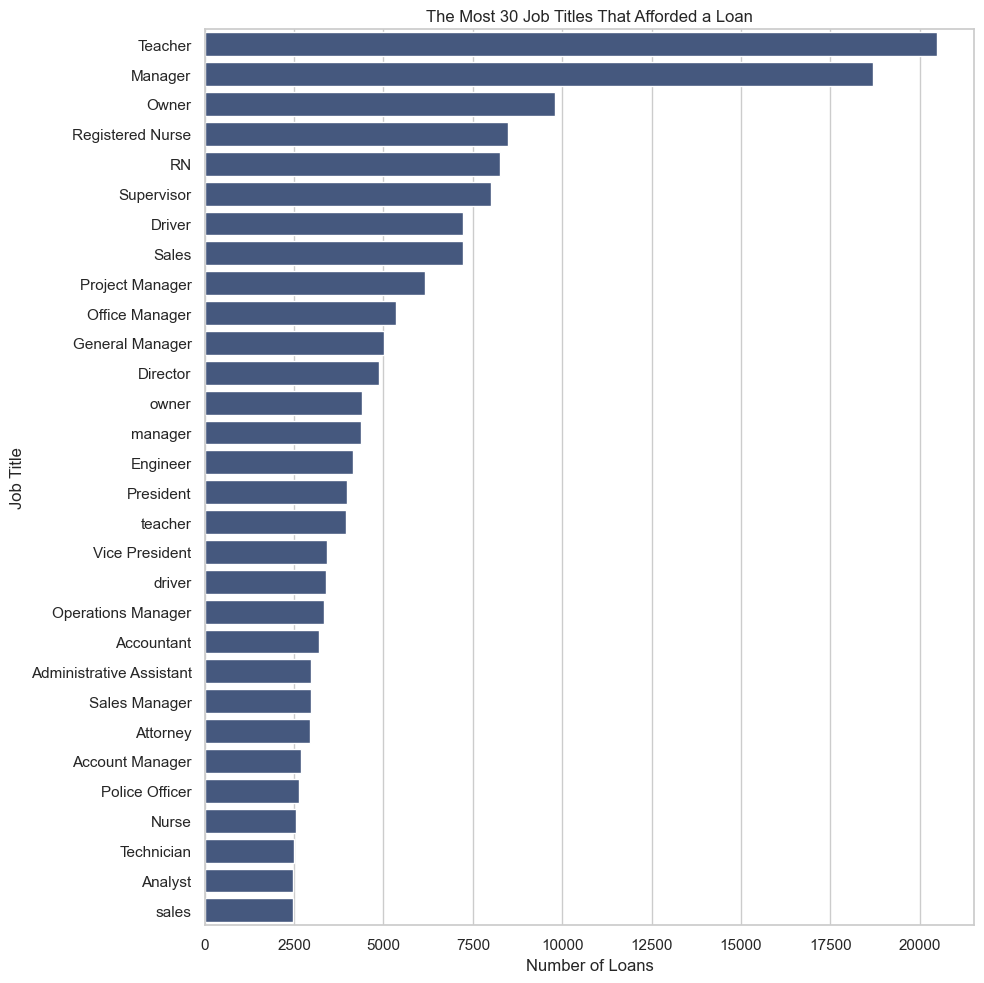

In [60]:
# Get the top 30 job titles by frequency
top_titles = filtered_df['emp_title'].value_counts().nlargest(30)

# Set plot style
sns.set(style='whitegrid')

# Set figure size (width=800px, height=800px approx)
plt.figure(figsize=(10, 10))

# Create a horizontal barplot
sns.barplot(
    x=top_titles.values,
    y=top_titles.index,
    color='#3c5587'  # Consistent color
)

# Customize layout
plt.title('The Most 30 Job Titles That Afforded a Loan')
plt.xlabel('Number of Loans')
plt.ylabel('Job Title')

# Tight layout and display
plt.tight_layout()
plt.show()

## Top 20 Most Common Employment Titles

This code identifies and prints the **top 20 most frequent job titles** in the `emp_title` column of the dataset.

###  Purpose:
- Understand which professions are most commonly represented among loan applicants.
- Provide insight into borrower occupation trends.
- Support grouping or categorization strategies for occupation-related analysis.

This analysis is useful for building borrower profiles or exploring correlations between job type and loan outcomes.


In [61]:
# Display the number of rows and columns where 'revol_util' is greater than 120
print(filtered_df[filtered_df.revol_util > 120].shape)

(110, 18)


## Plot of Revolving Line Utilization Rate by Loan Status

This plot visualizes the distribution of `revol_util` (revolving line utilization rate) among borrowers, grouped by their loan status (e.g., *Fully Paid* vs *Charged Off*).

### Purpose:
- Observe how revolving credit usage correlates with loan outcomes.
- Identify whether high credit utilization is associated with a higher risk of default.
- Support credit risk modeling and borrower profiling.

The histogram is grouped (not stacked), allowing for a clear side-by-side comparison of loan status across utilization bins.


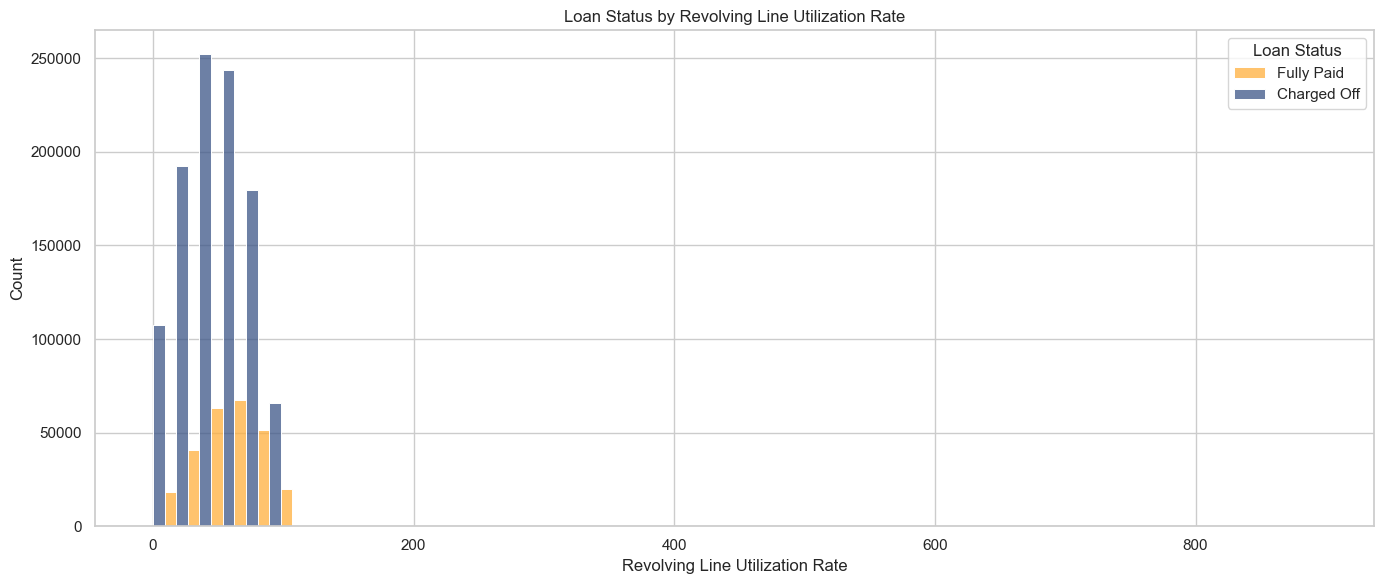

In [63]:
# Plot histogram of 'revol_util' grouped by 'loan_status' (non-stacked)
sns.set(style='whitegrid')

# Set the figure size (width=1000px ≈ 14 inches)
plt.figure(figsize=(14, 6))

# Create a grouped histogram using sns.histplot with hue (non-stacked)
sns.histplot(
    data=filtered_df,
    x='revol_util',
    hue='loan_status',
    bins=50,
    multiple='dodge',  # This ensures bars are grouped side-by-side (not stacked)
    palette={'Fully Paid': '#3c5587', 'Charged Off': '#ffaf3c'}
)

# Customize axes and title
plt.title('Loan Status by Revolving Line Utilization Rate')
plt.xlabel('Revolving Line Utilization Rate')
plt.ylabel('Count')

# Force a legend to appear even if Seaborn skips it
handles, labels = ax.get_legend_handles_labels()
if handles:
    plt.legend(handles=handles, labels=labels, title='Loan Status')
else:
    plt.legend(['Fully Paid', 'Charged Off'], title='Loan Status')

# Tight layout and display
plt.tight_layout()
plt.show()

## Plot of Revolving Line Utilization Rate by Loan Status (Filtered < 120)

This plot shows the distribution of `revol_util` values less than 120, grouped by loan status.

### Purpose:
- Focus on typical revolving utilization values by excluding extreme outliers.
- Compare loan outcomes within a reasonable range of utilization.
- Enhance insights on how utilization relates to loan repayment performance.


C:\Users\Ak\AppData\Local\Temp\ipykernel_9504\3225180162.py:24: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Loan Status')


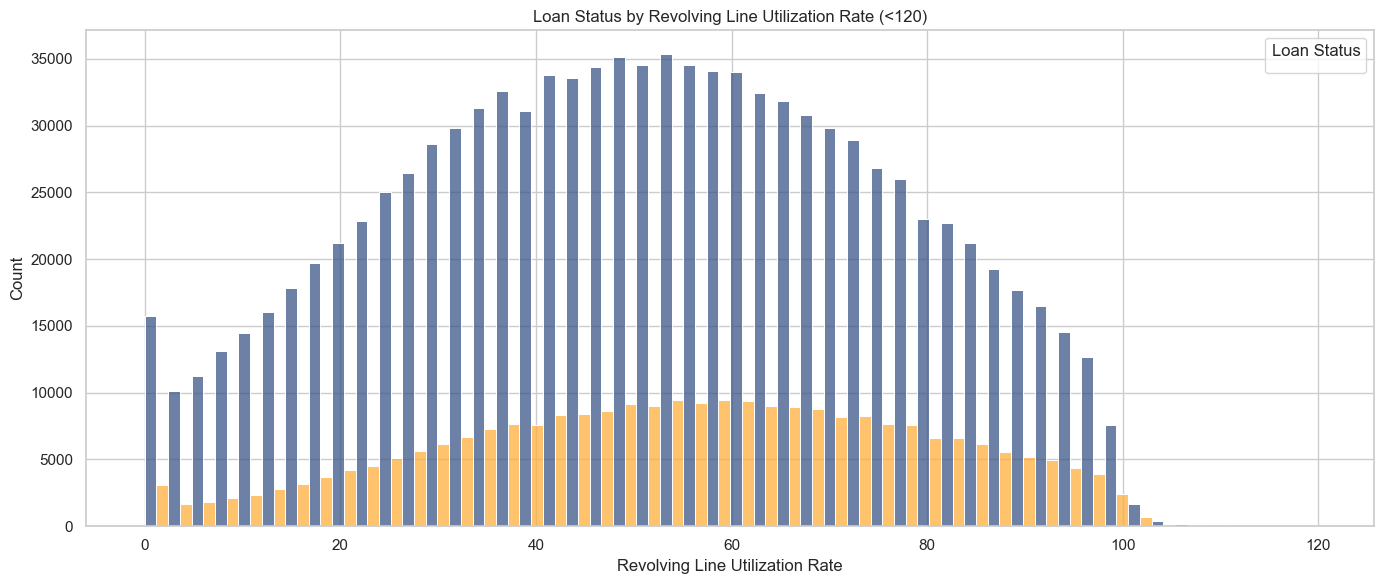

In [64]:
# Filter the data to revol_util < 120
filtered_data = filtered_df[filtered_df['revol_util'] < 120]

# Set seaborn style
sns.set(style='whitegrid')

# Set the figure size (same as Plotly: 1000x600 ≈ 14x6 inches)
plt.figure(figsize=(14, 6))

# Create a grouped histogram
sns.histplot(
    data=filtered_data,
    x='revol_util',
    hue='loan_status',
    bins=50,
    multiple='dodge',  # Group bars side-by-side
    palette={'Fully Paid': '#3c5587', 'Charged Off': '#ffaf3c'}
)

# Customize the plot
plt.title('Loan Status by Revolving Line Utilization Rate (<120)')
plt.xlabel('Revolving Line Utilization Rate')
plt.ylabel('Count')
plt.legend(title='Loan Status')
plt.tight_layout()

# Show the plot
plt.show()

## Checking for Extremely High Revolving Utilization Values

This command filters the dataset to find rows where the `revol_util` (revolving line utilization) is greater than 200%, which is unusually high and may indicate data errors or outliers.


In [65]:
# Filter the DataFrame to show rows where 'revol_util' is greater than 200
extreme_revol_util = filtered_df[filtered_df.revol_util > 200]

# Display the filtered rows with revol_util > 200
print(extreme_revol_util)

         loan_amnt        term  int_rate  installment grade sub_grade  \
2001302      16500   60 months     14.49       388.14     C        C4   
2039647       3500   36 months     12.49       117.08     B        B4   

              emp_title emp_length home_ownership  annual_inc  \
2001302       sales rep   < 1 year       MORTGAGE    48000.00   
2039647  Budget Analyst  10+ years           RENT    45000.00   

        verification_status  loan_status             purpose   dti  open_acc  \
2001302     Source Verified  Charged Off  debt_consolidation  9.33      4.00   
2039647            Verified   Fully Paid  debt_consolidation 14.67      2.00   

         revol_util application_type  loan_status_encoded  
2001302      366.60       Individual                    1  
2039647      892.30       Individual                    0  


In [66]:
for column in filtered_df.columns:
    if filtered_df[column].isna().sum() != 0:
        missing = filtered_df[column].isna().sum()
        portion = (missing / filtered_df.shape[0]) * 100
        print(f"'{column}': number of missing values '{missing}' => '{portion:.3f}%'")

'emp_title': number of missing values '82579' => '6.335%'
'emp_length': number of missing values '75454' => '5.788%'
'dti': number of missing values '312' => '0.024%'
'revol_util': number of missing values '810' => '0.062%'


## Checking Missing Values by Column

This code iterates over all columns in the DataFrame to identify columns with missing values.  
It prints the number of missing entries and the percentage of missing data relative to the total rows.


## Handling Missing Data and Feature Cleaning

- Drop the `emp_title` column because it has a high missing rate and is not predictive.
- Impute missing values in `emp_length` with the mode since it's categorical.
- Impute missing values in `dti` and `revol_util` with their median values, as they are numerical.


In [67]:
# Drop 'emp_title' column — high missing rate and low predictive value
filtered_df = filtered_df.drop(columns=['emp_title'])

# Fill missing 'emp_length' values with the mode (most common category)
filtered_df['emp_length'] = filtered_df['emp_length'].fillna(filtered_df['emp_length'].mode()[0])

# Fill missing numerical columns 'dti' and 'revol_util' with their respective medians
filtered_df['dti'] = filtered_df['dti'].fillna(filtered_df['dti'].median())
filtered_df['revol_util'] = filtered_df['revol_util'].fillna(filtered_df['revol_util'].median())

## Encoding Categorical Variables

- Apply label encoding to ordinal-like columns (`term`, `emp_length`, `home_ownership`, `verification_status`, `application_type`) to convert categories into numeric labels.
- Apply one-hot encoding to nominal columns (`purpose`,`grade` and `sub_grade`) to create binary indicator variables, dropping the first category to avoid multicollinearity.


In [68]:

# Label encode ordinal-like fields
label_cols = ['term', 'emp_length', 'home_ownership', 'verification_status', 'application_type']
for col in label_cols:
    filtered_df[col] = LabelEncoder().fit_transform(filtered_df[col])

# One-hot encode nominal fields 'purpose' and 'grade','sub_grade' dropping the first category
filtered_df = pd.get_dummies(filtered_df, columns=['purpose', 'grade','sub_grade'], drop_first=True)

## Preparing Data for Modeling

- Define feature matrix `X` by dropping the target column `loan_status`.
- Define target vector `y` by mapping loan statuses to binary labels (`0` for Fully Paid, `1` for Charged Off`).
- Split the dataset into training and testing sets with stratification to preserve class distribution.
- Apply SMOTE (Synthetic Minority Over-sampling Technique) on the training set to balance the classes by generating synthetic samples for the minority class.


In [69]:
# Define features (X) and binary target (y)
X = filtered_df.drop(columns=['loan_status', 'loan_status_encoded'], errors='ignore')
y = filtered_df['loan_status'].map({'Fully Paid': 0, 'Charged Off': 1})


# Split data into training and test sets with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

# Apply SMOTE to balance the training set
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

## Train, Predict, and Evaluate LightGBM Classifier

- Initialize a LightGBM classifier with a fixed random state for reproducibility.
- Train the model on the balanced training set created by SMOTE.
- Predict loan status on the test set.
- Evaluate the model’s performance using classification report and confusion matrix.


In [70]:
# Initialize LightGBM classifier
model = lgb.LGBMClassifier(random_state=42)

# Train the model on the SMOTE-resampled training data
model.fit(X_train_res, y_train_res)

# Predict loan status on the test set
y_pred = model.predict(X_test)

# Print classification report to show precision, recall, f1-score
print(classification_report(y_test, y_pred, target_names=['Fully Paid', 'Charged Off']))

# Print confusion matrix to visualize true vs predicted labels
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

[LightGBM] [Info] Number of positive: 833561, number of negative: 833561
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.851343 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1915
[LightGBM] [Info] Number of data points in the train set: 1667122, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
              precision    recall  f1-score   support

  Fully Paid       0.81      0.98      0.89    208391
 Charged Off       0.49      0.09      0.16     52331

    accuracy                           0.80    260722
   macro avg       0.65      0.53      0.52    260722
weighted avg       0.75      0.80      0.74    260722

Confusion Matrix:
[[203233   5158]
 [ 47409   4922]]


## Plot Feature Importance of the LightGBM Model

This plot displays the top 10 most important features based on their gain, which reflects the contribution of each feature to improving the model's accuracy.


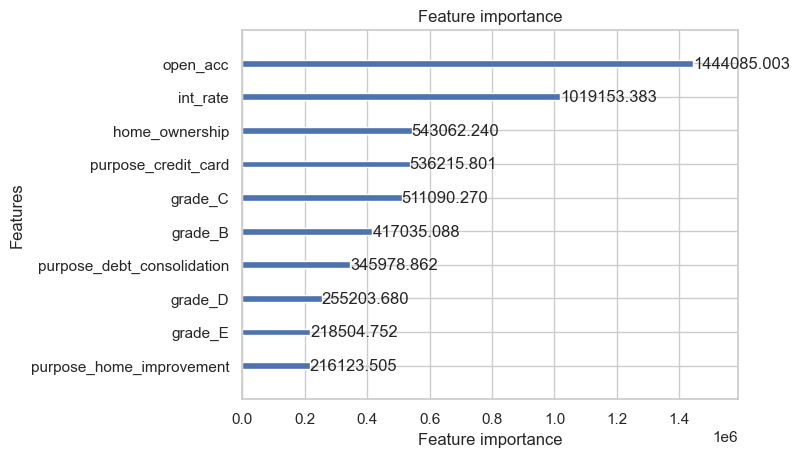

In [71]:
# Plot the top 10 features by importance using the 'gain' metric
lgb.plot_importance(model, max_num_features=10, importance_type='gain')

# Show the plot
plt.show()